In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
# from tensorflow.keras import backend as K
import shutil,os
import pickle

In [4]:
final_df = pd.read_csv('./final_df_next_day_10.csv').reset_index(drop=True)
final_df

Date  lowest_price  wma7 closing_price  dema7 highest_price  \
0     2013-01-02      0.000000            0.000000             0.000000   
1     2013-01-03      0.000003            0.000000             0.000000   
2     2013-01-04      0.000003            0.000000             0.000000   
3     2013-01-05      0.000001            0.000000             0.000000   
4     2013-01-06      0.000004            0.000000             0.000000   
...          ...           ...                 ...                  ...   
4027  2024-01-15      0.628370            0.665035             0.647225   
4028  2024-01-16      0.633658            0.661176             0.642320   
4029  2024-01-17      0.635644            0.657461             0.636998   
4030  2024-01-18      0.612128            0.650330             0.631920   
4031  2024-01-19      0.606686            0.647268             0.624358   

      dema7 opening_price  tema30 closing_price  sma7 highest_price  \
0                0.000000              0.000000            0.000000   
1                0.000000              0.000000            0.000000   
2                0.000000              0.000000            0.000000   
3                0.000000              0.000000            0.000000   
4                0.000000              0.000000            0.000000   
...                   ...                   ...                 ...   
4027             0.652530              0.667463            0.687220   
4028             0.646989              0.664940            0.677939   
4029             0.648027              0.661625            0.668231   
4030             0.646401              0.654712            0.654998   
4031             0.635981              0.649579            0.645661   

      ema7 closing_price  dema7 lowest_price  highest_price  \
0               0.000000            0.000000   1.304773e-06   
1               0.000000            0.000000   5.798991e-07   
2               0.000000            0.000000   1.594722e-06   
3               0.000000            0.000000   1.304773e-06   
4               0.000000            0.000000   5.798991e-07   
...                  ...                 ...            ...   
4027            0.671146            0.654130   6.280255e-01   
4028            0.670030            0.652583   6.314544e-01   
4029            0.667687            0.652681   6.258897e-01   
4030            0.660326            0.642314   6.214523e-01   
4031            0.656108            0.633352   6.110253e-01   

      tema7 closing_price  next_day_closing_price  
0                0.000000                   13.09  
1                0.000000                   13.19  
2                0.000000                   13.19  
3                0.000000                   13.15  
4                0.000000                   13.15  
...                   ...                     ...  
4027             0.629234                43131.47  
4028             0.634182                42741.63  
4029             0.634482                41292.17  
4030             0.622773                41629.02  
4031             0.619840                41689.62  

[4032 rows x 12 columns]

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

We decided to create multiple splits and train model for each split separately. Each train split will consist of 500 data points and the next 100 data points will be used for testing.

In [6]:
train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|██████████| 36/36 [00:00<00:00, 18044.33it/s]


In [7]:
def visualize_split(batch_no,show_plot=True):
    final_df.plot(x='Date',y='next_day_closing_price',figsize=(25,5))
    for i in range(train_splits[batch_no].index[0],train_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(test_splits[batch_no].index[0],test_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Temporal Window Split-{batch_no+1}')
    if not os.path.exists('/content/plot'):
        os.makedirs('/content/plot')
        
    plt.savefig(f'/content/plot/Temporal Window Split-{batch_no+1}.png')
    plt.show()

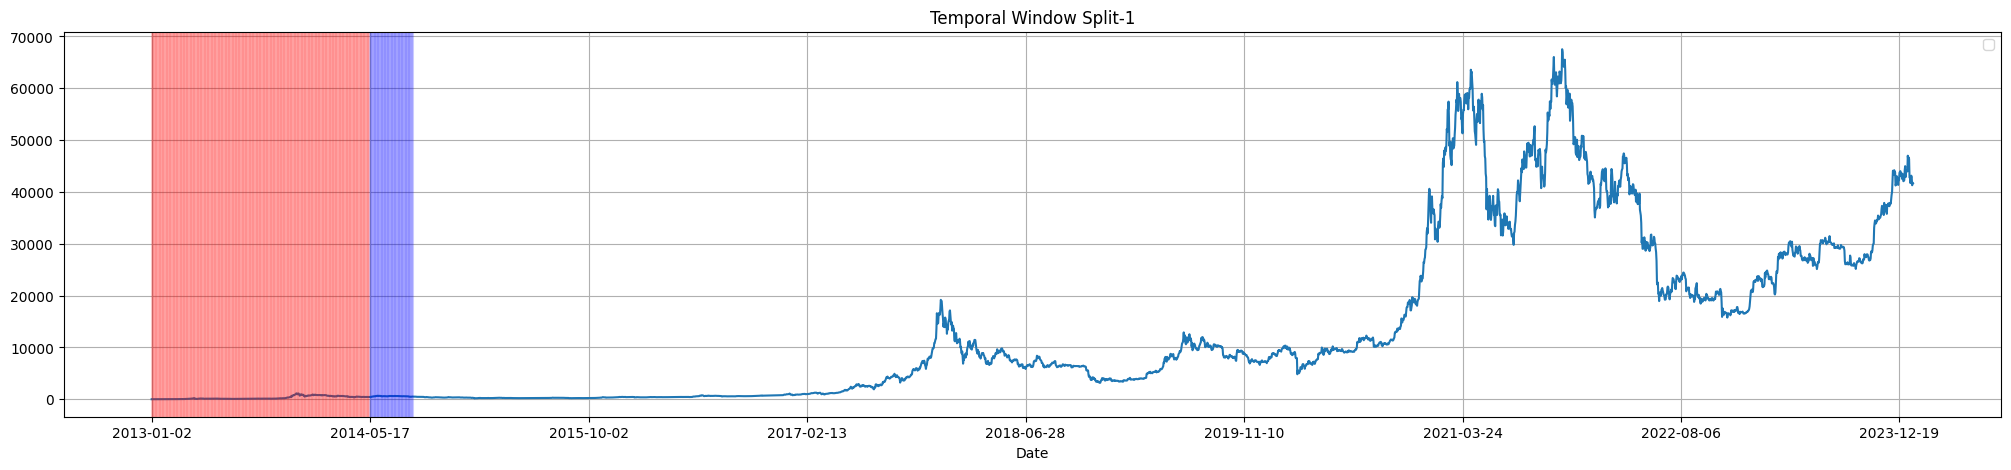

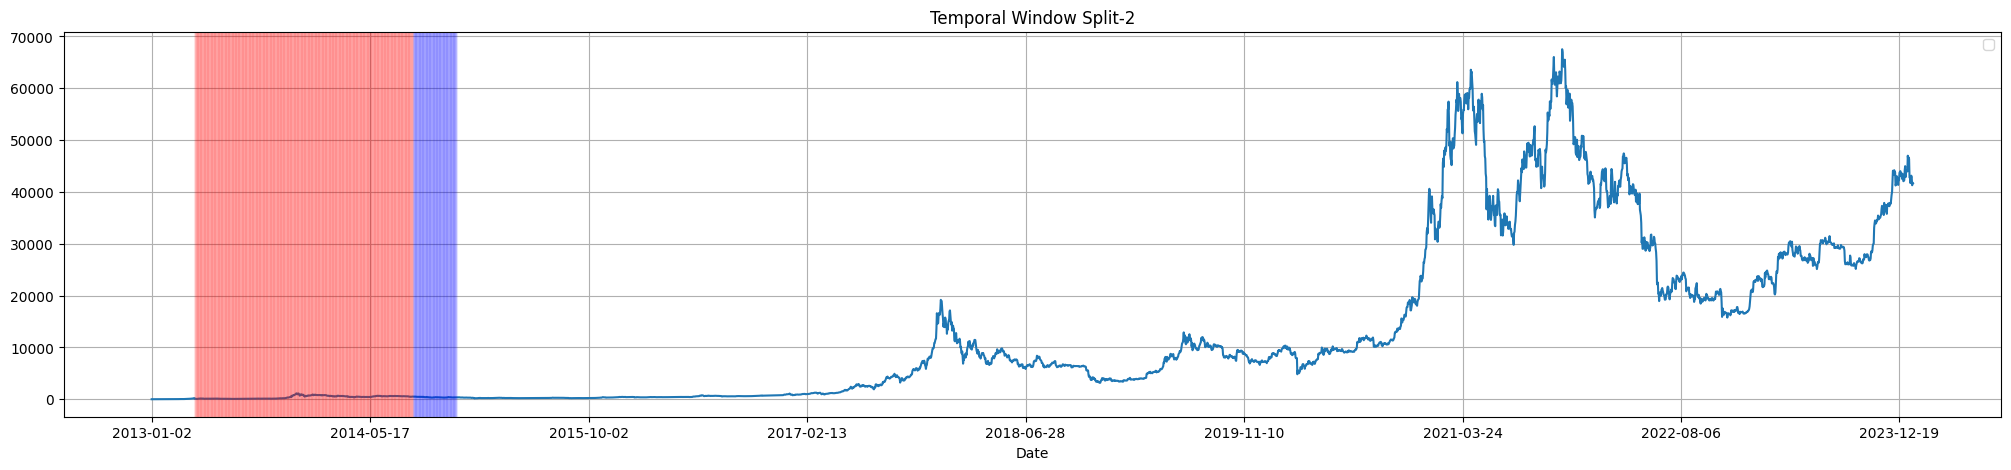

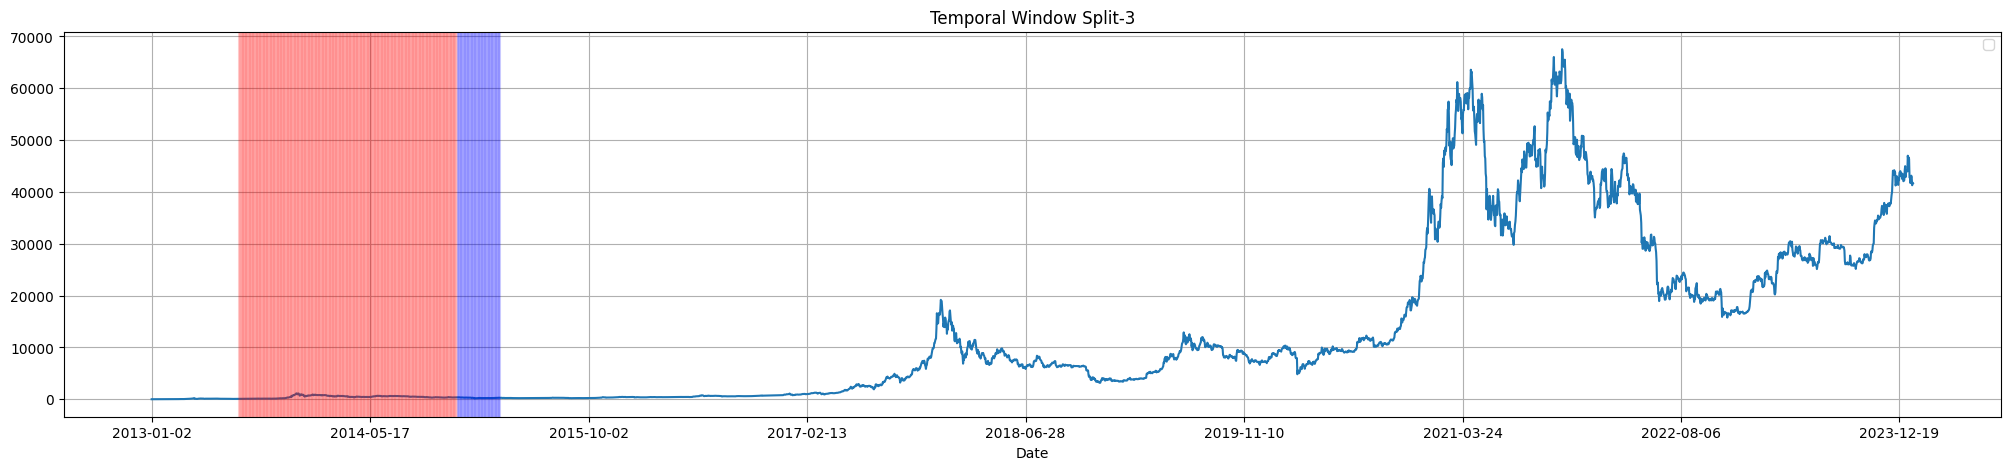

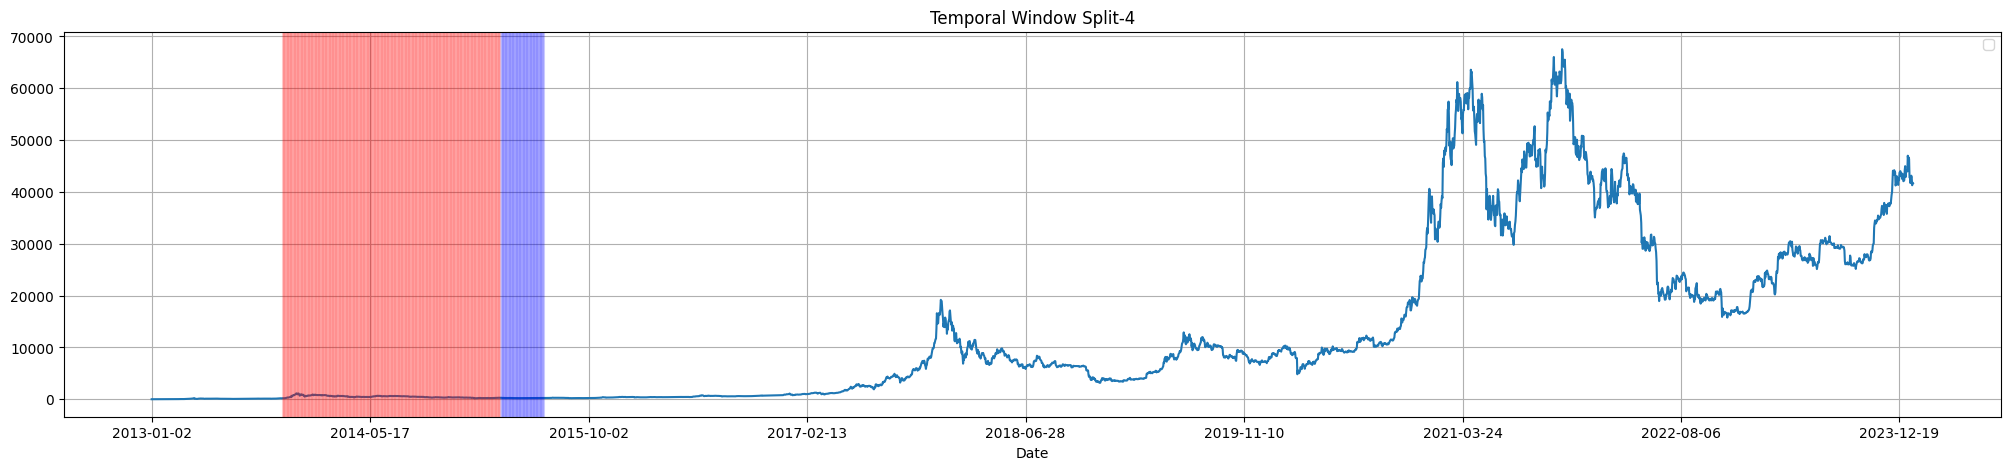

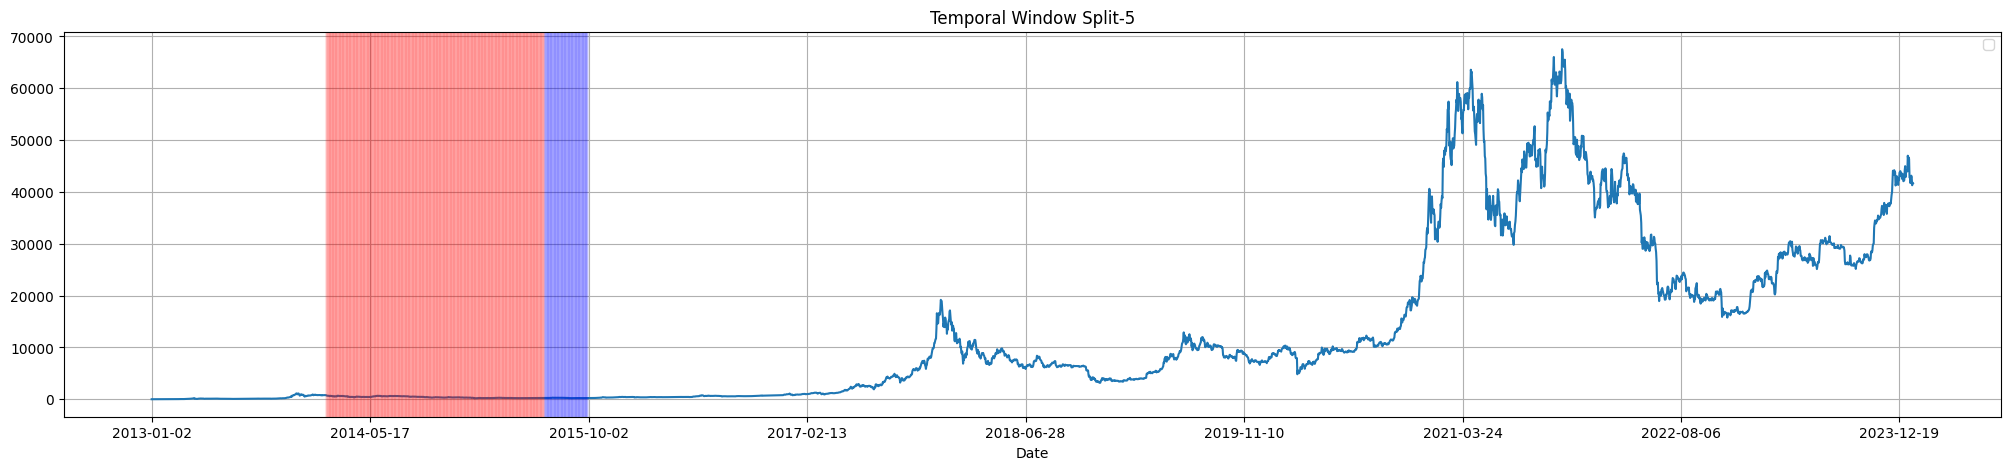

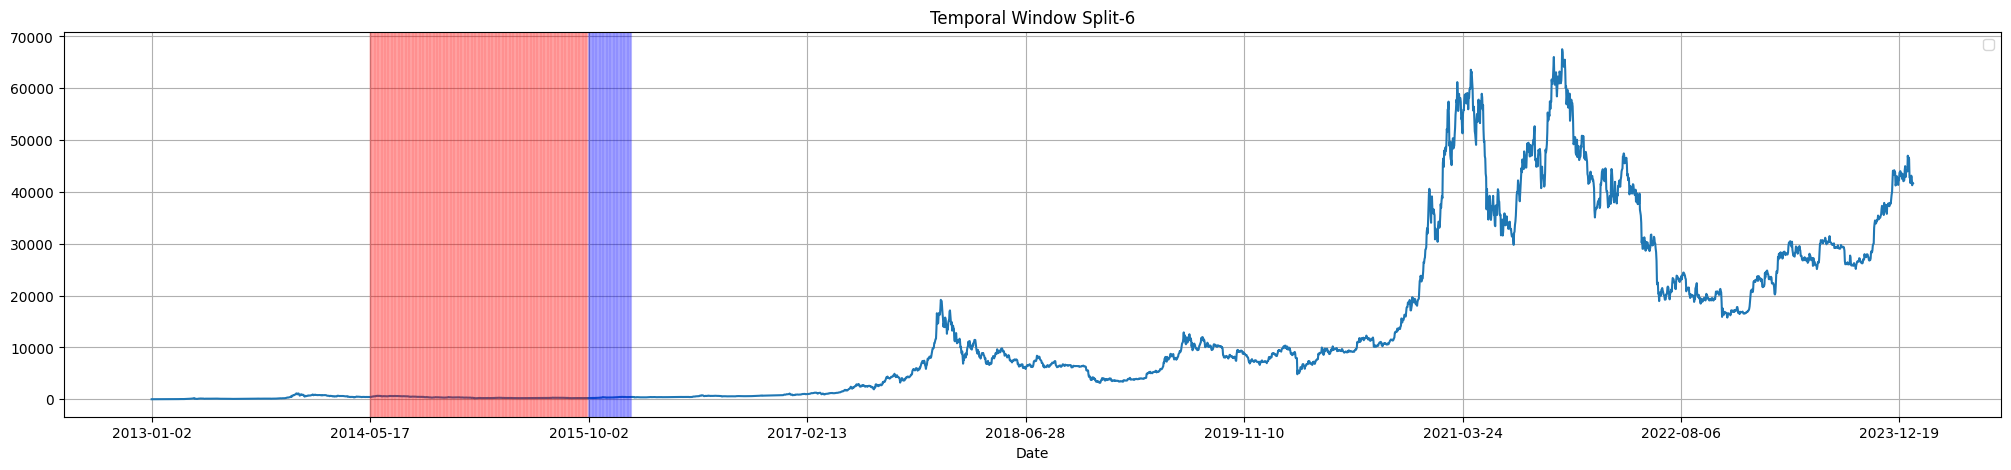

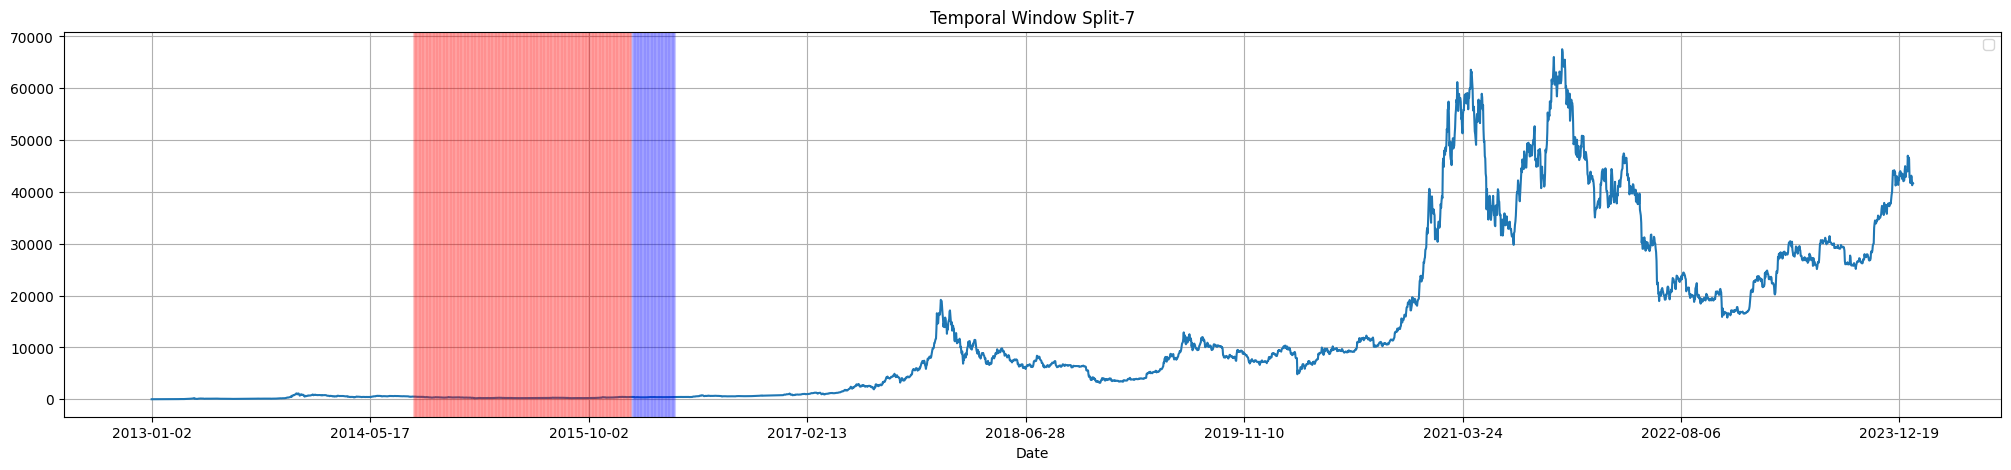

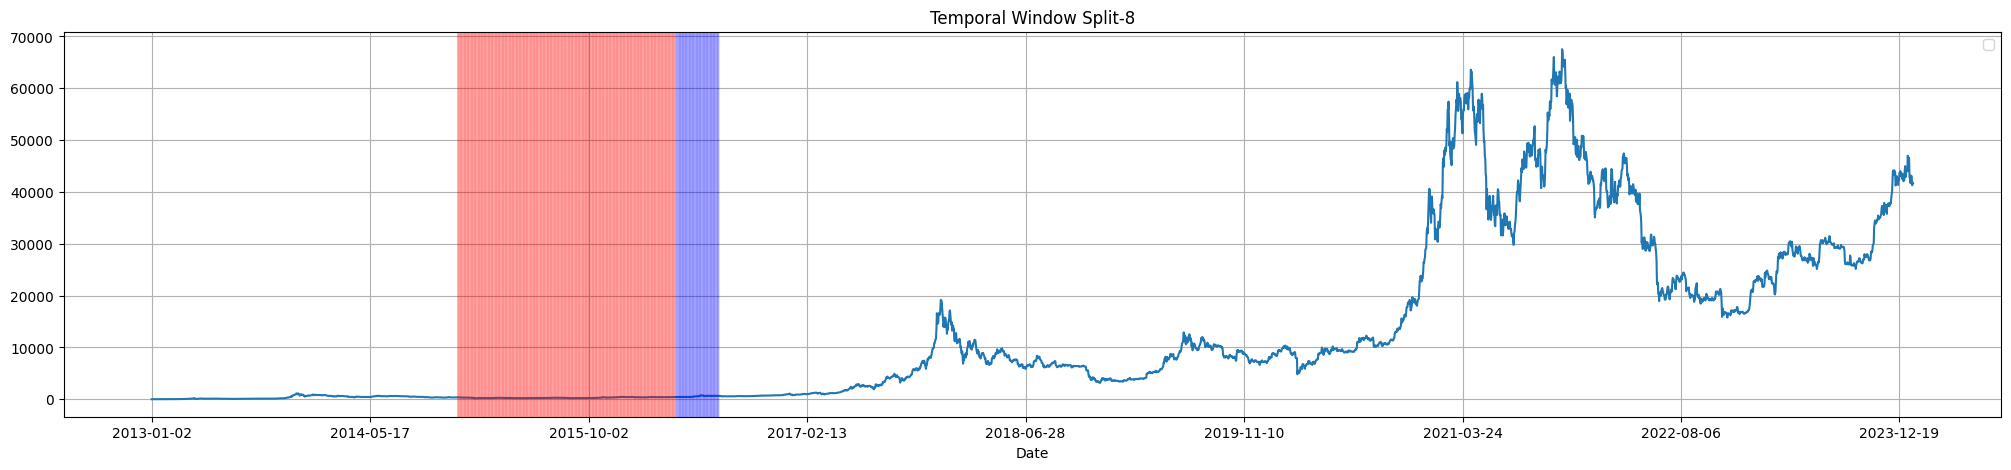

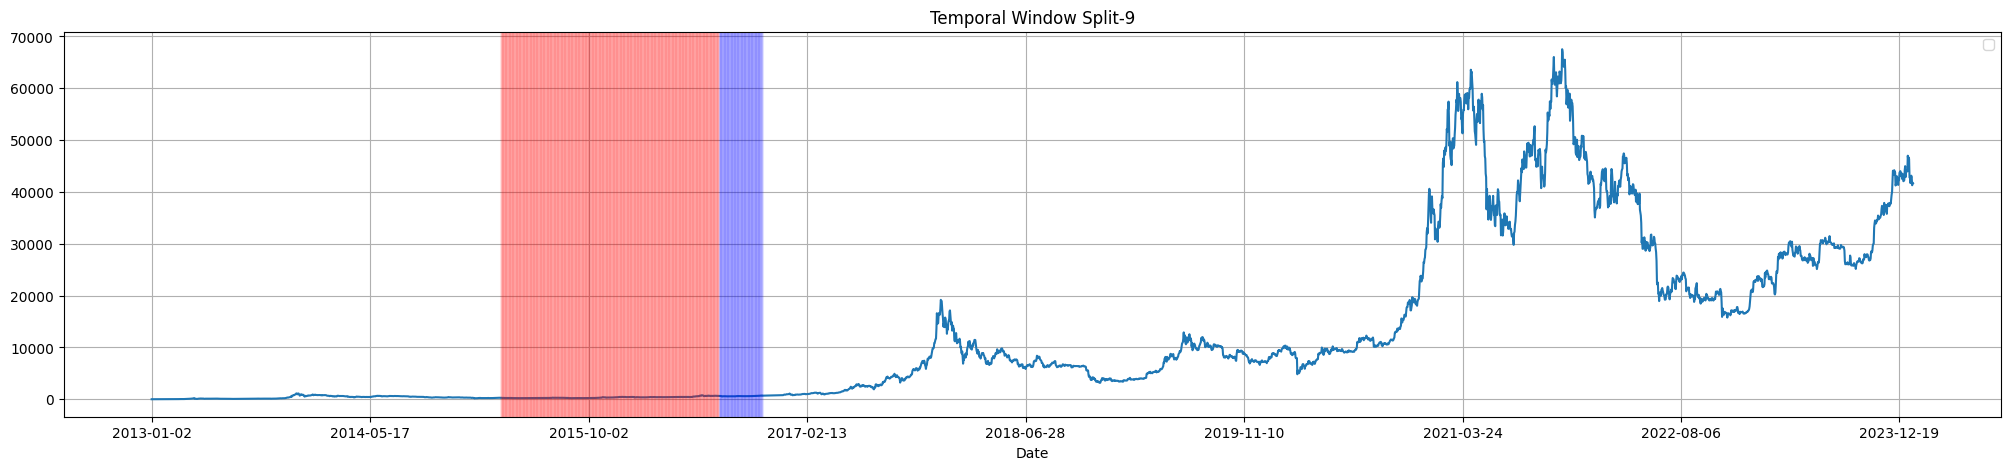

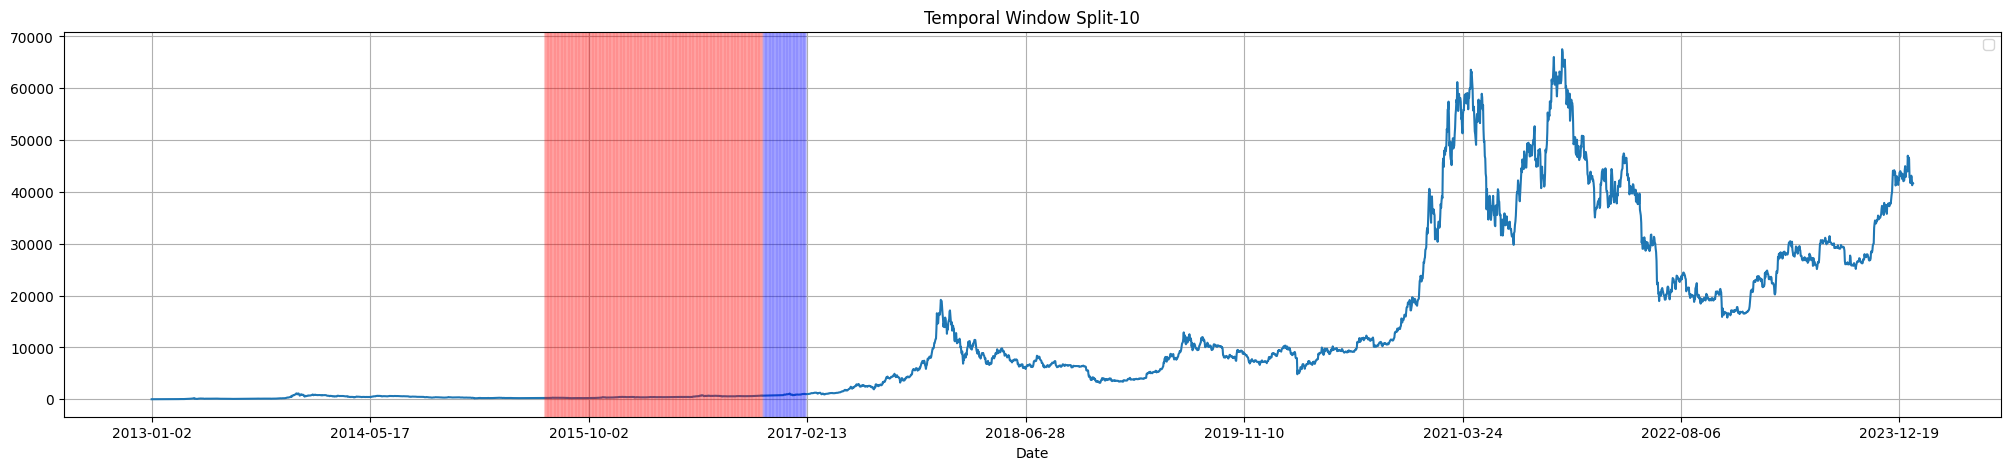

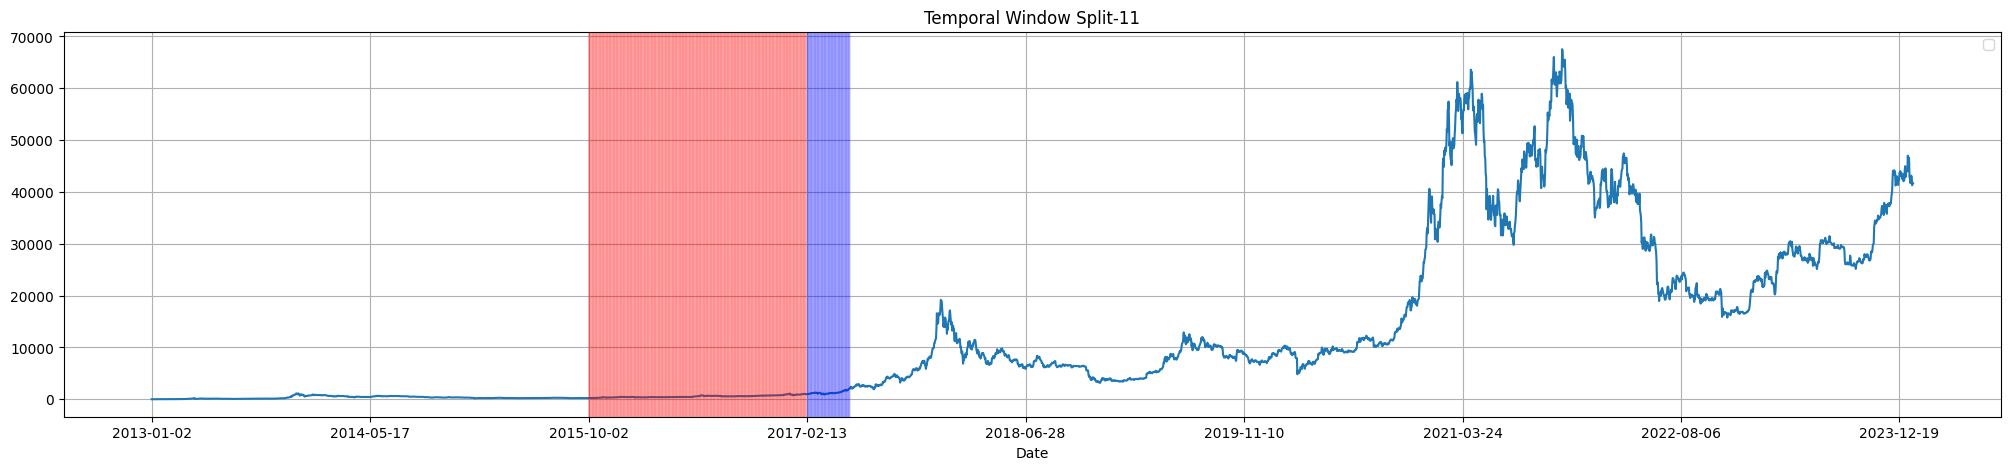

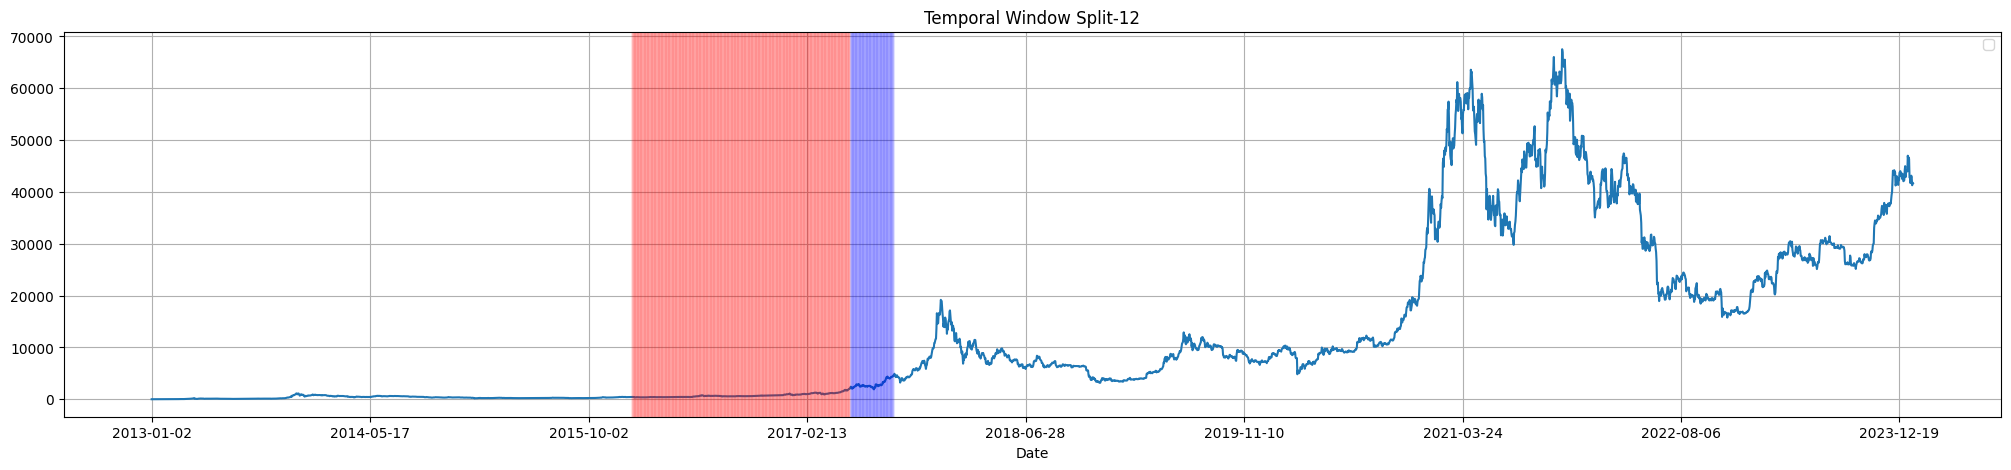

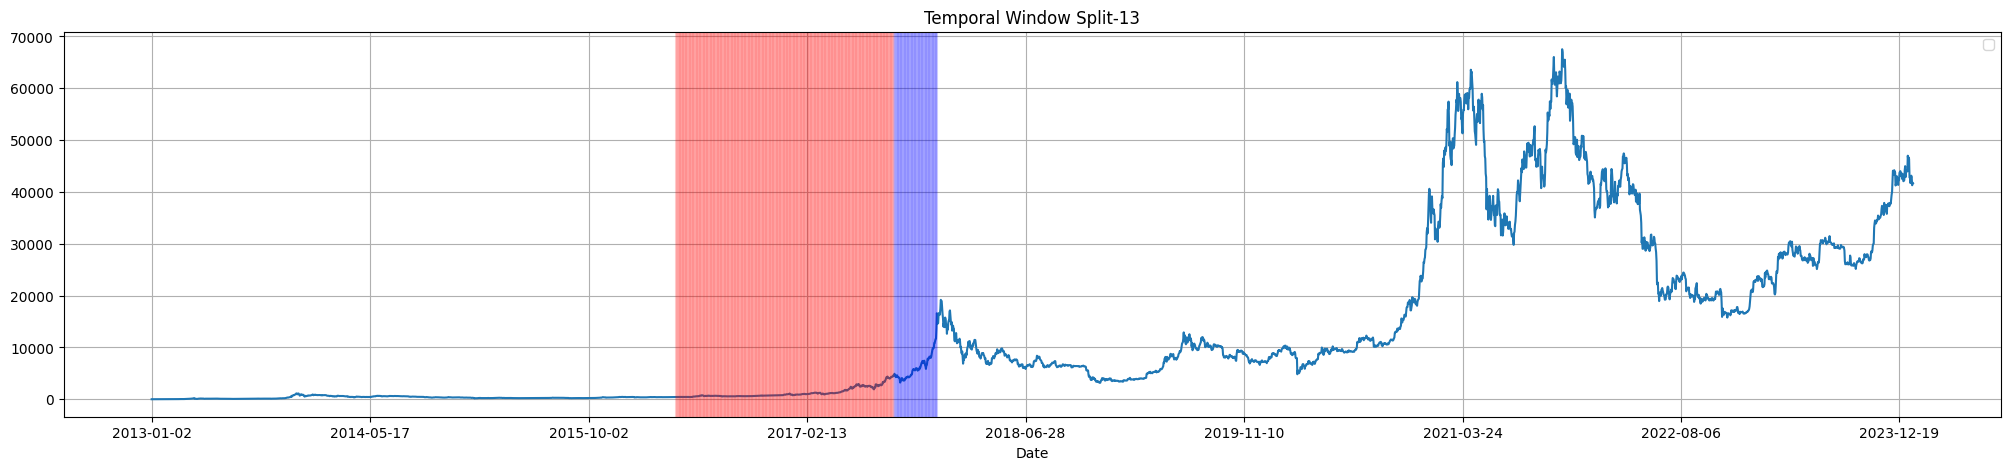

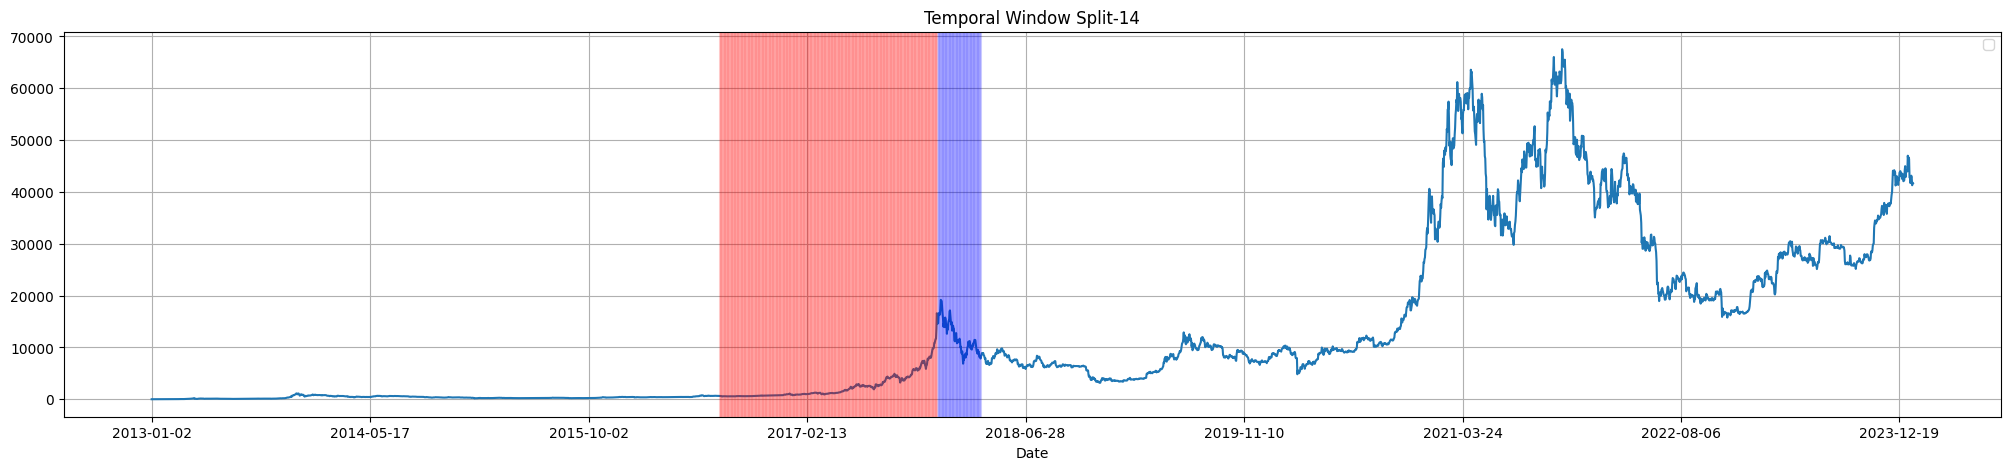

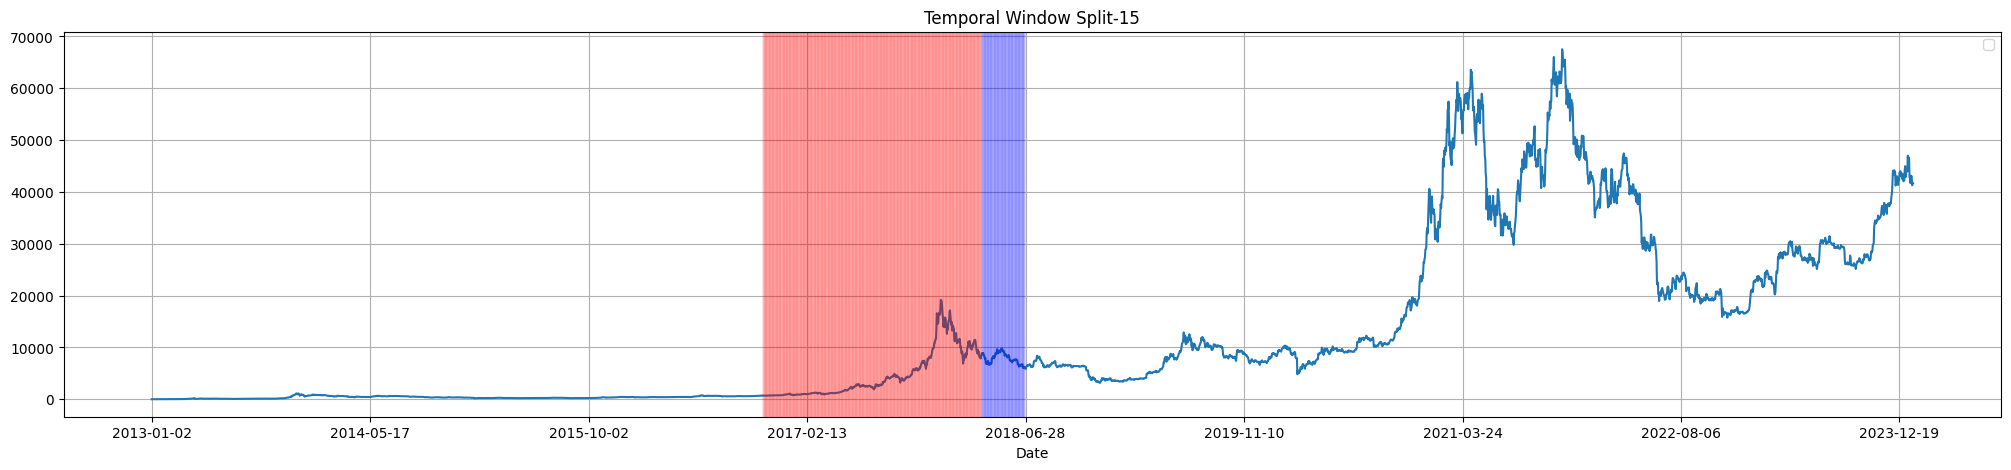

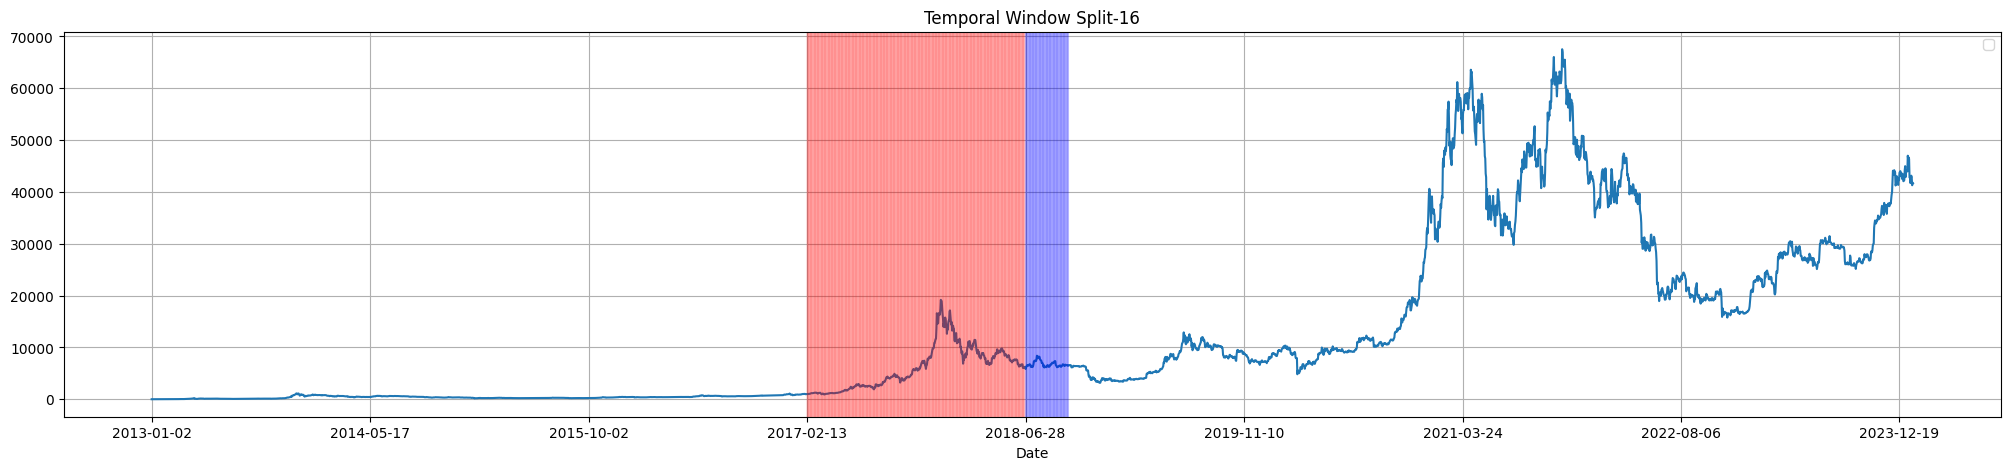

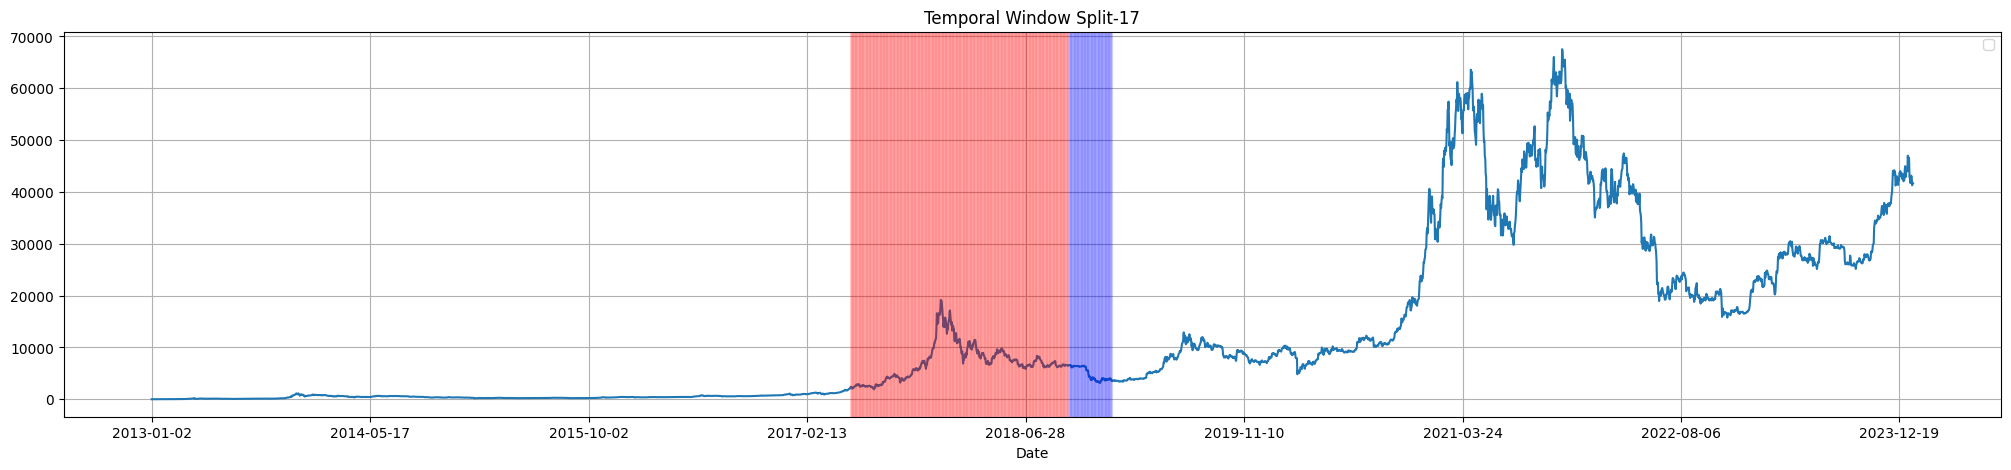

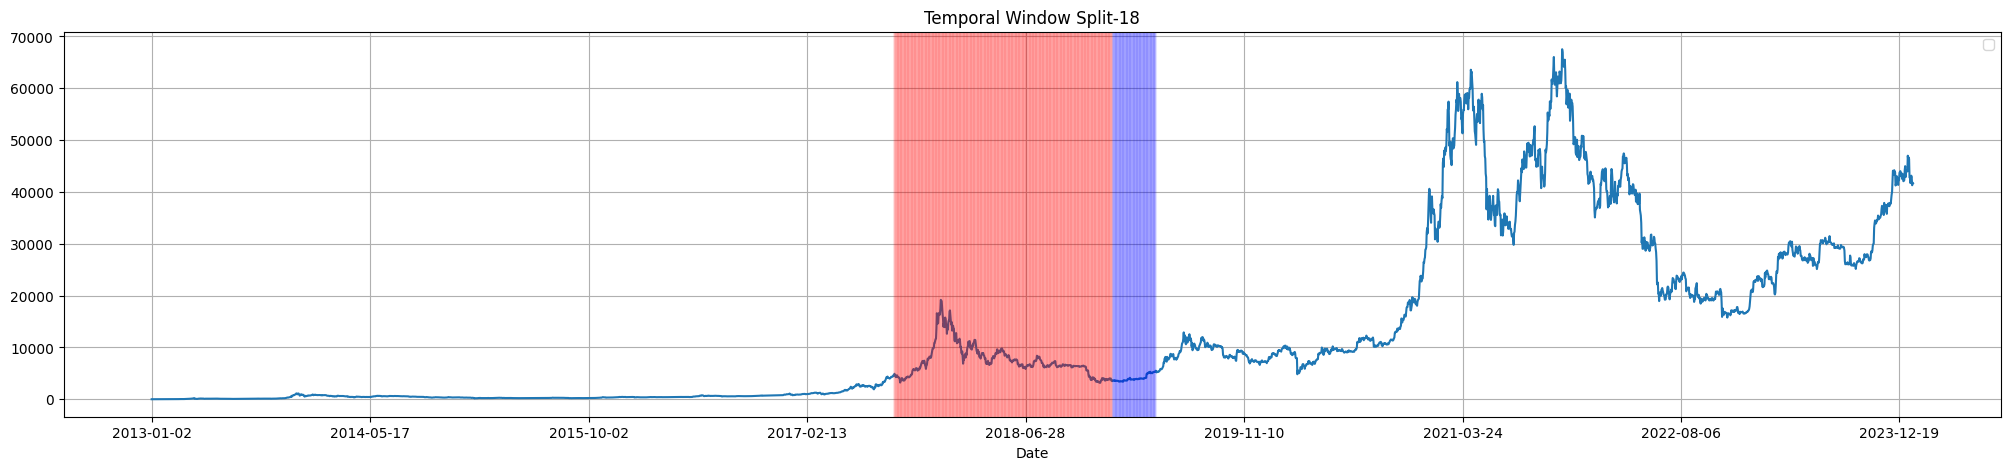

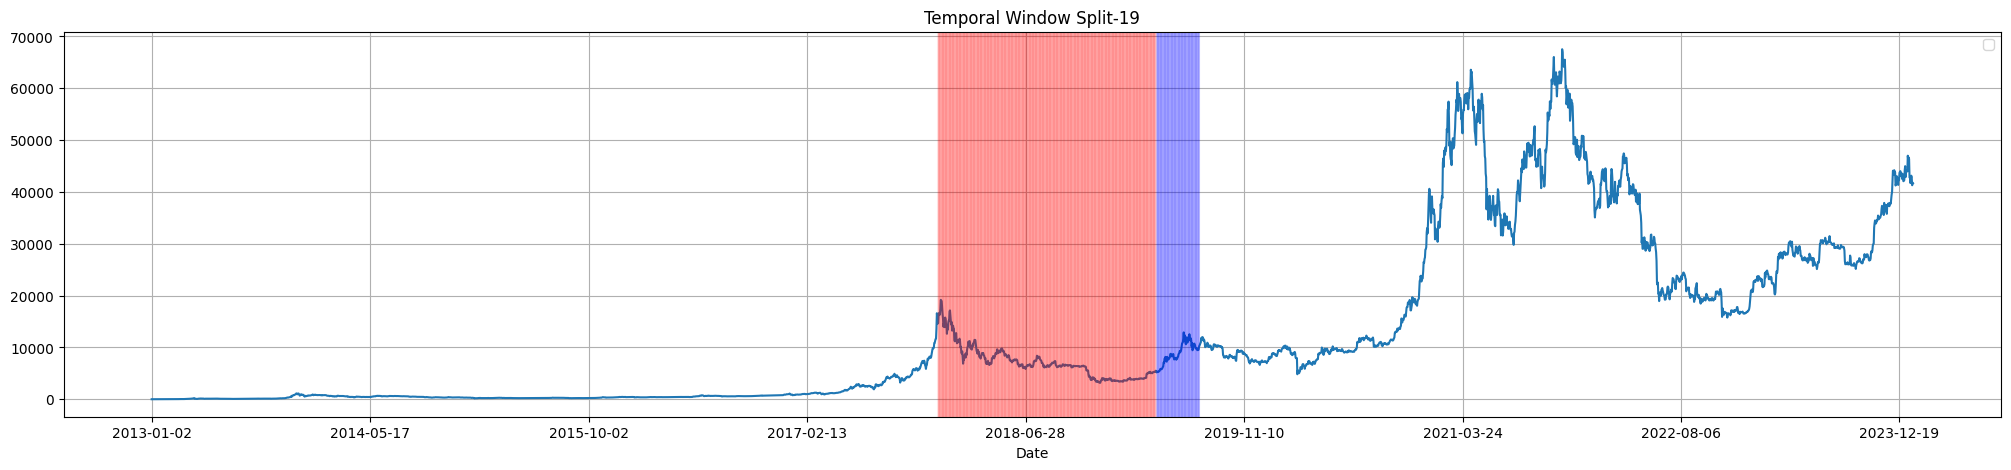

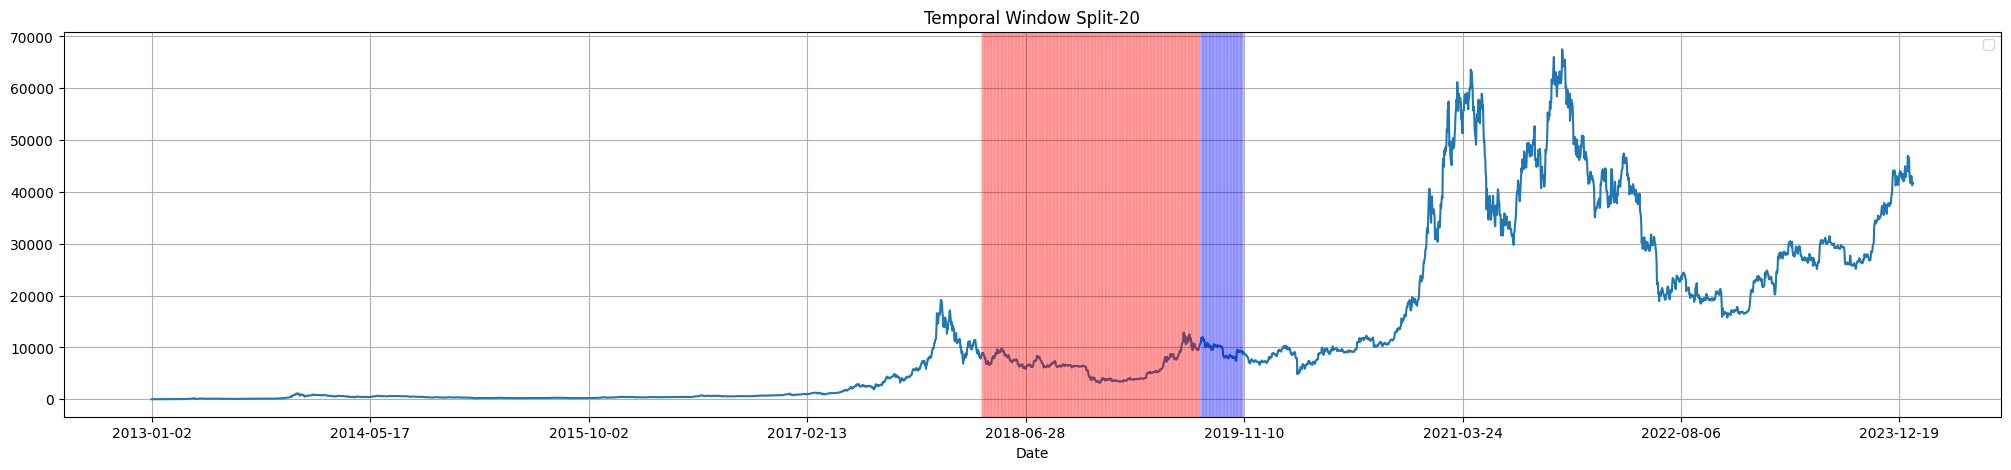

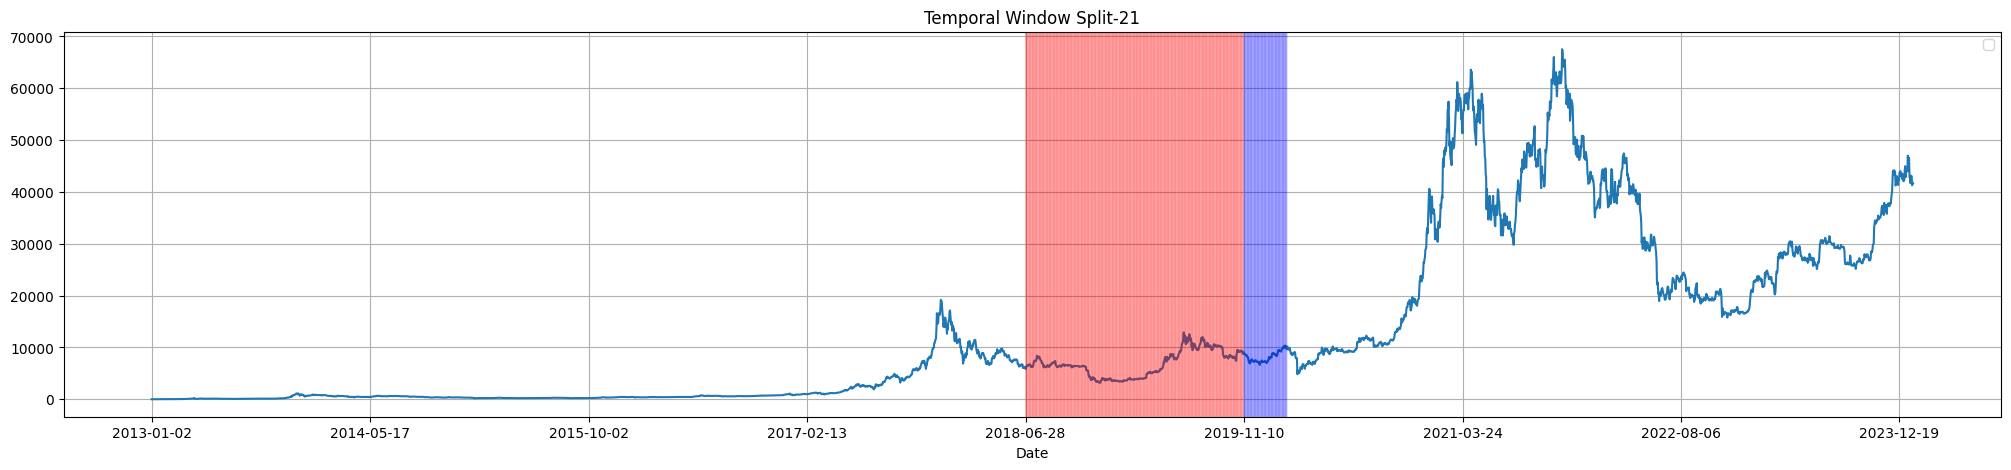

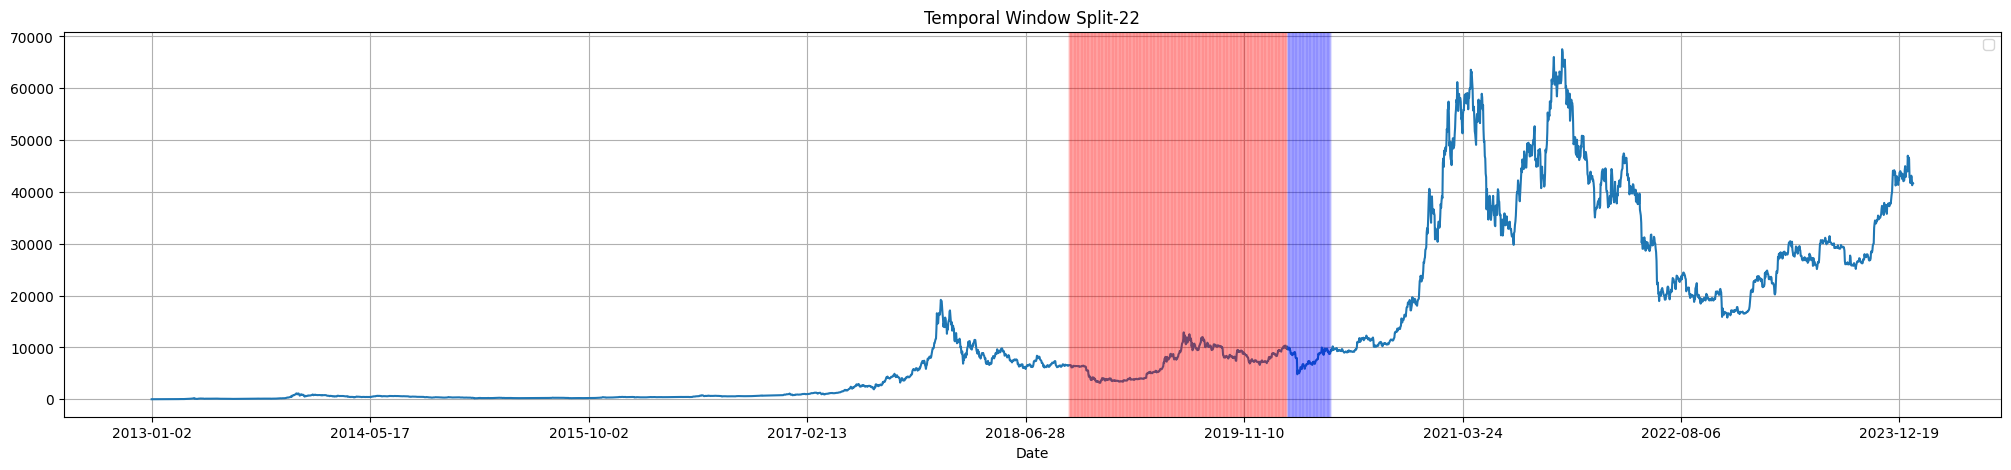

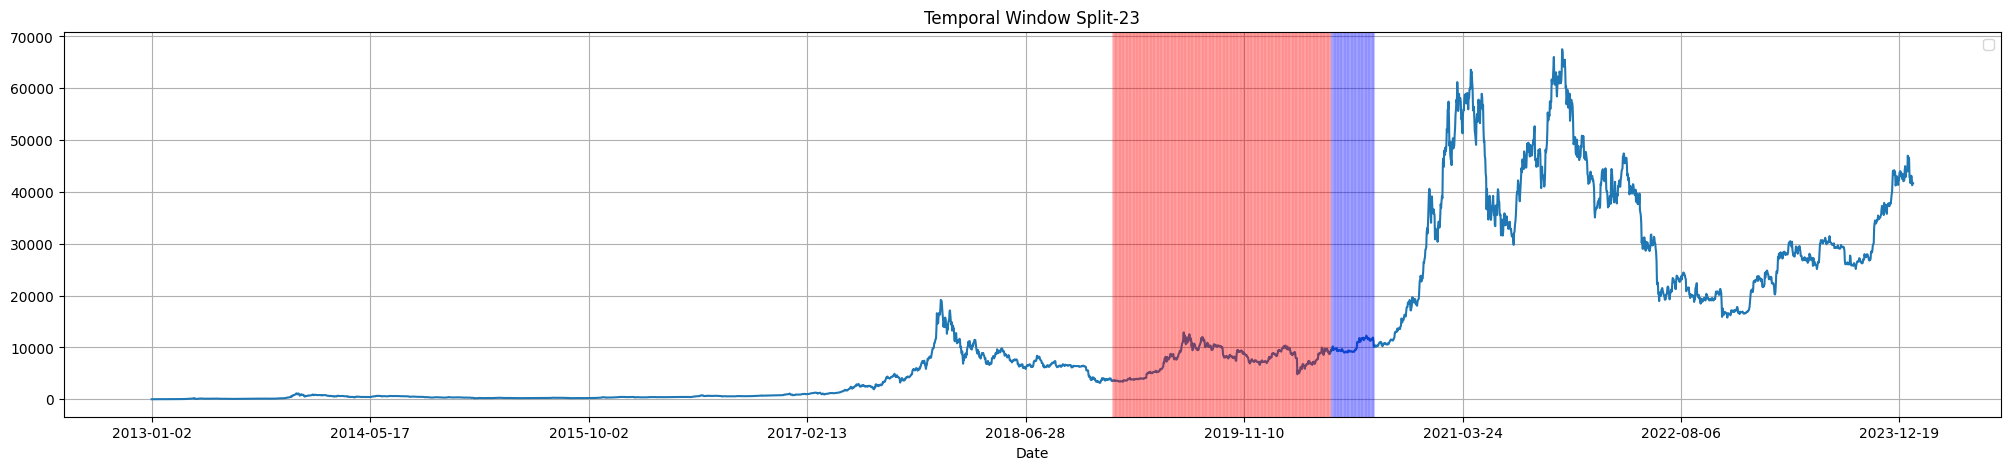

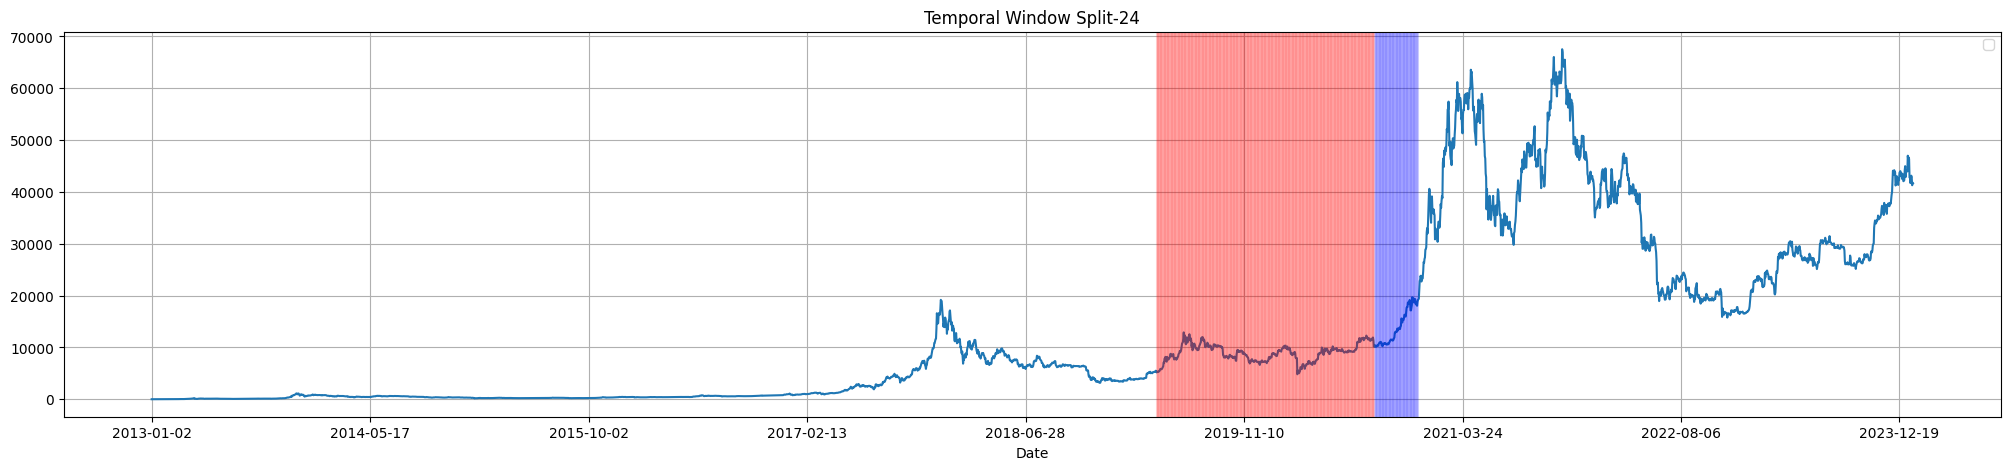

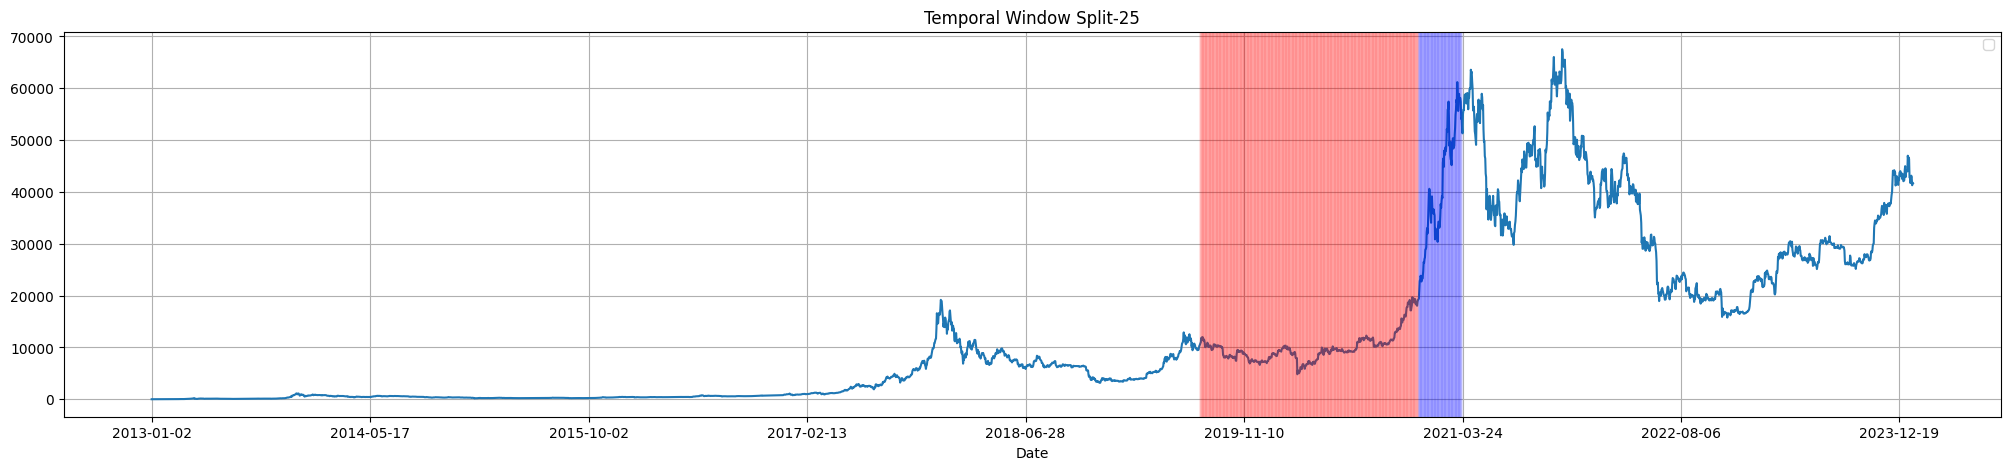

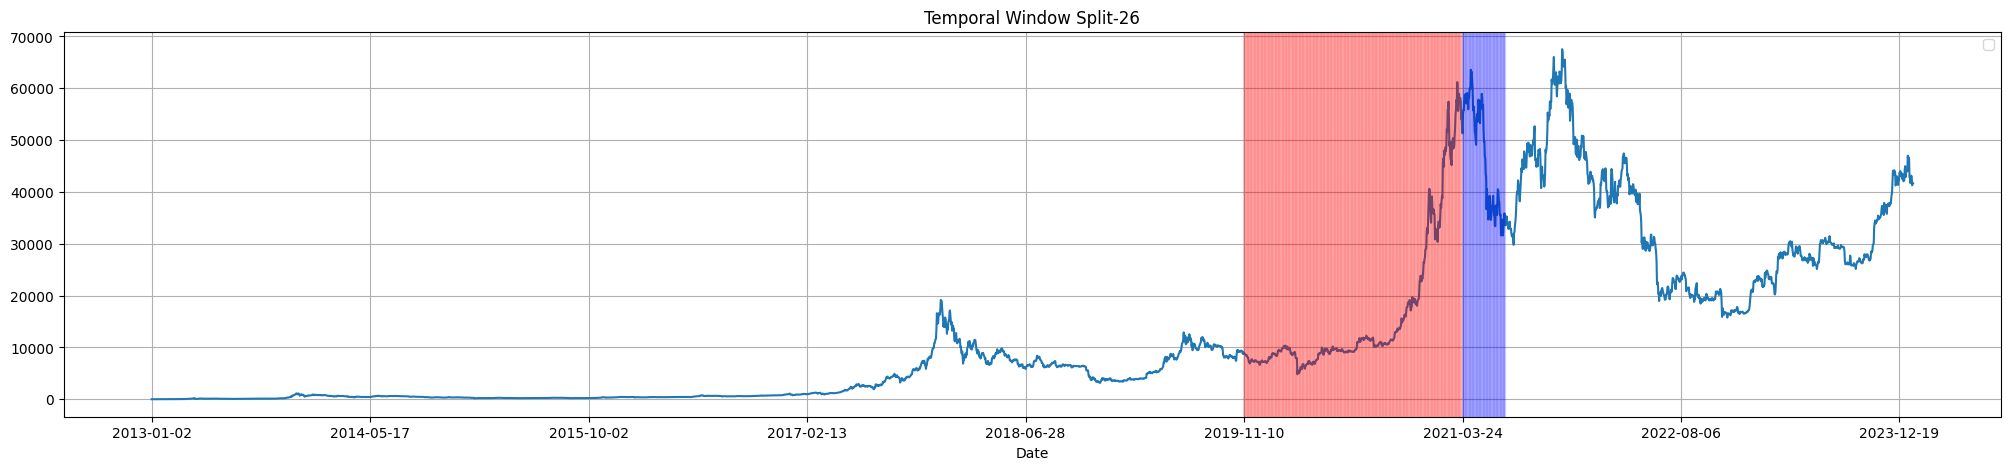

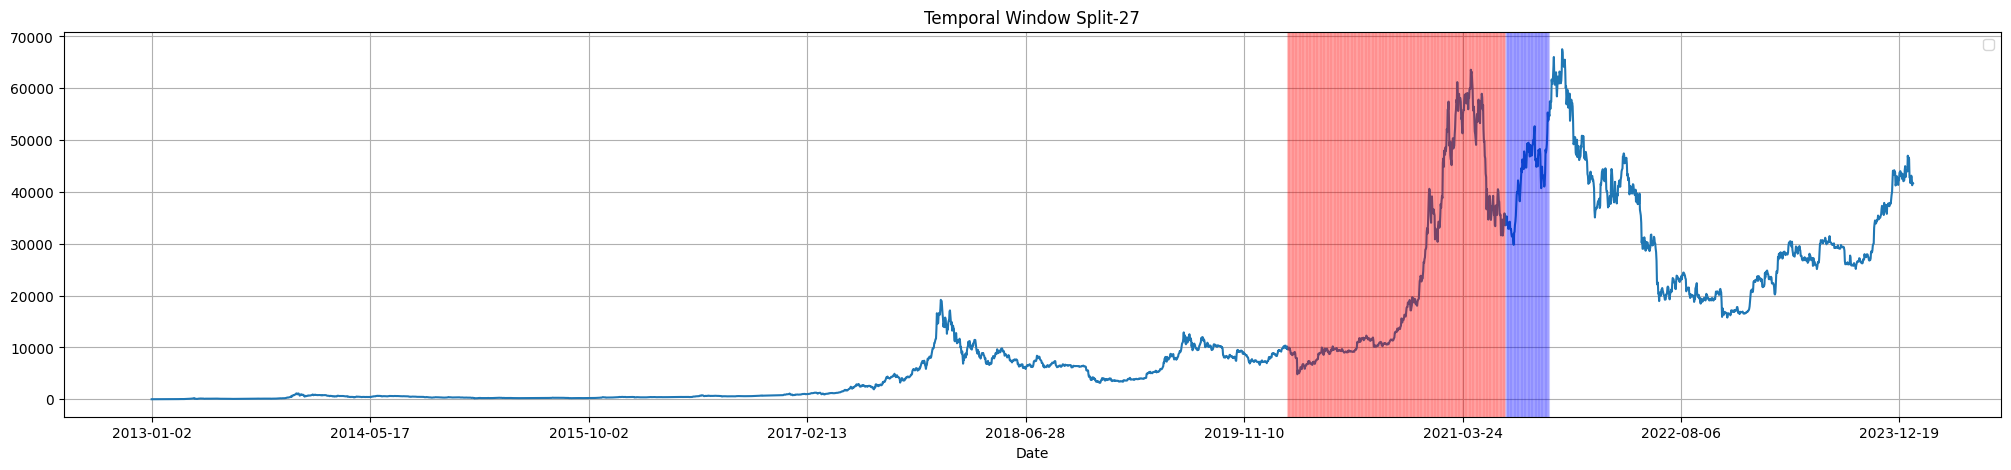

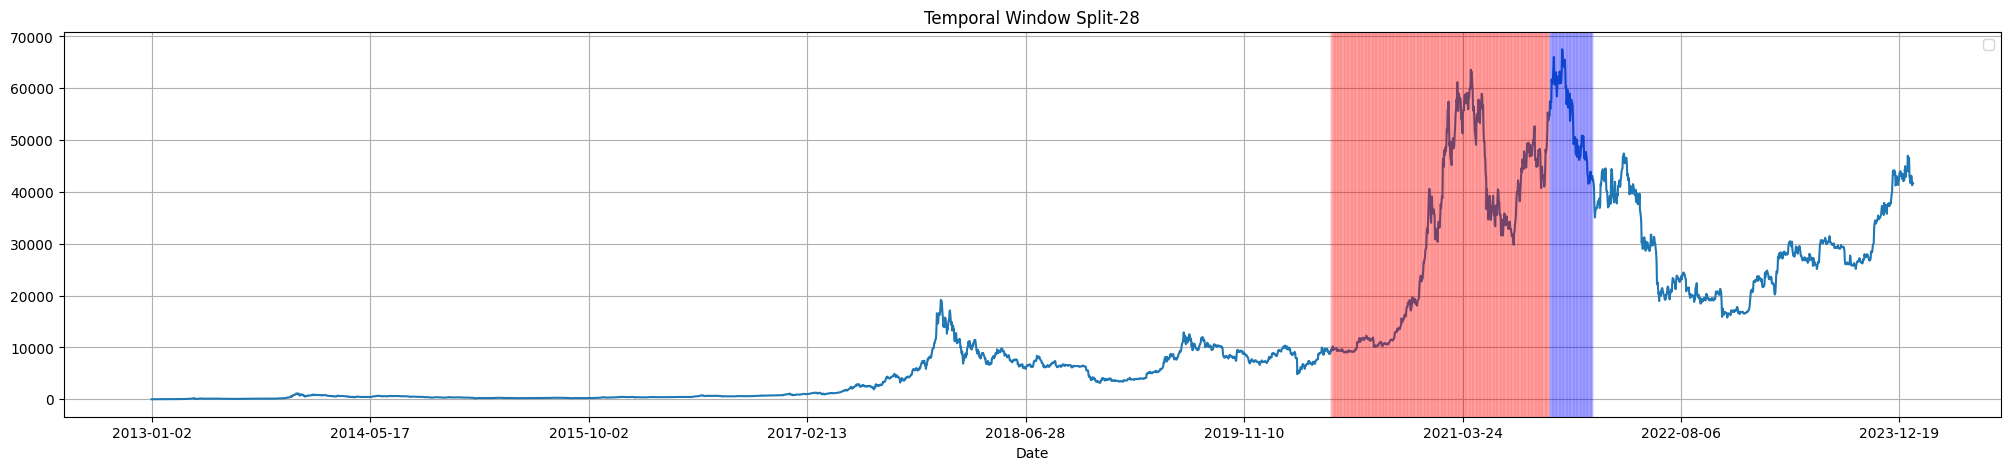

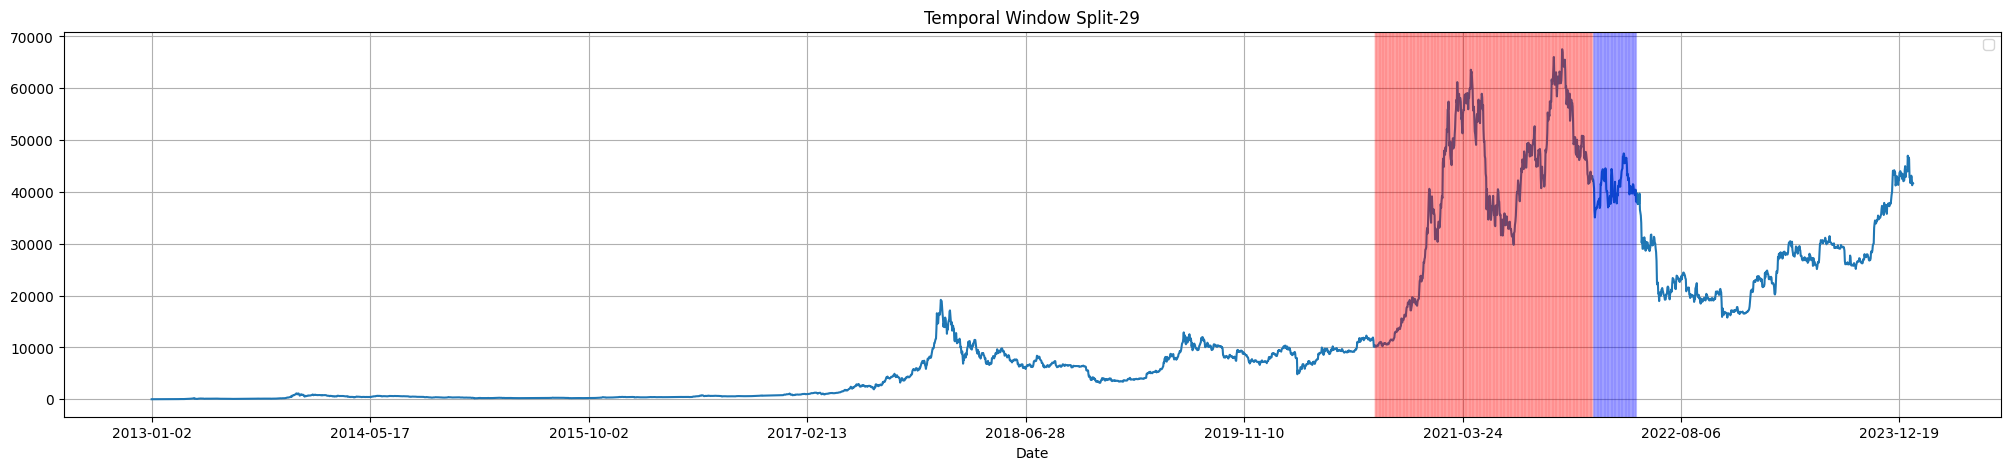

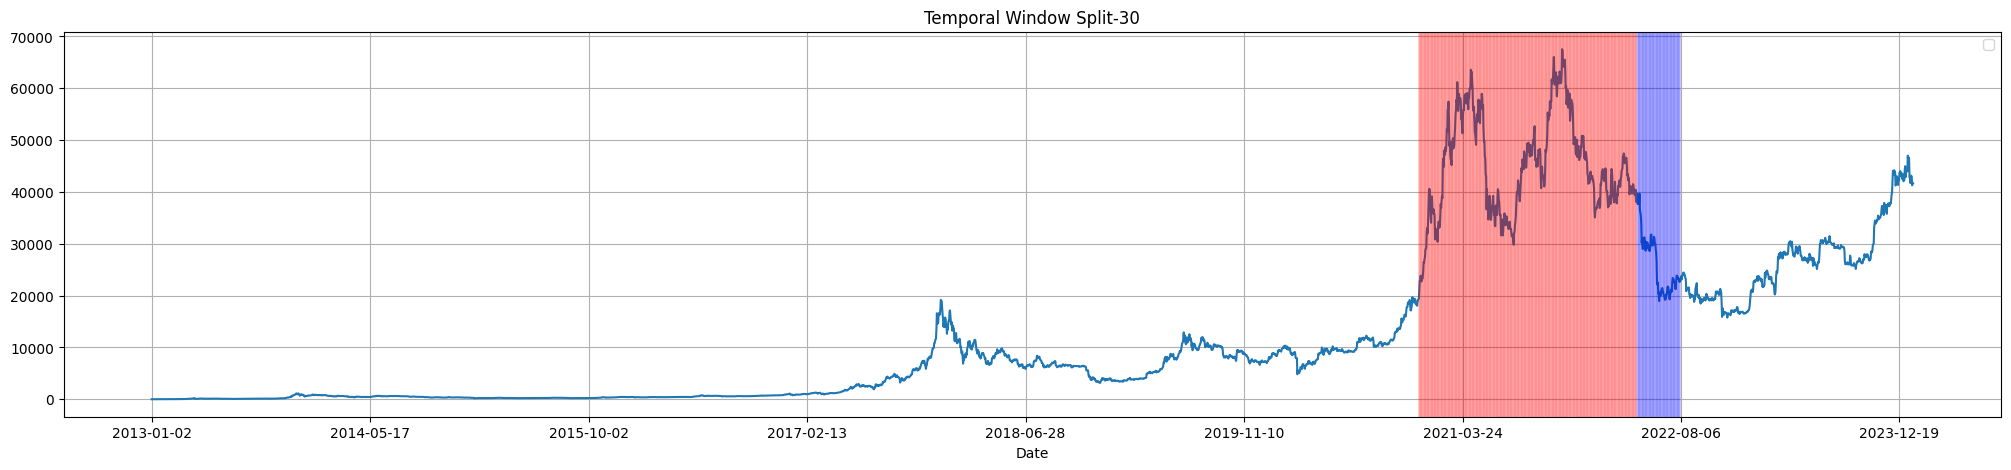

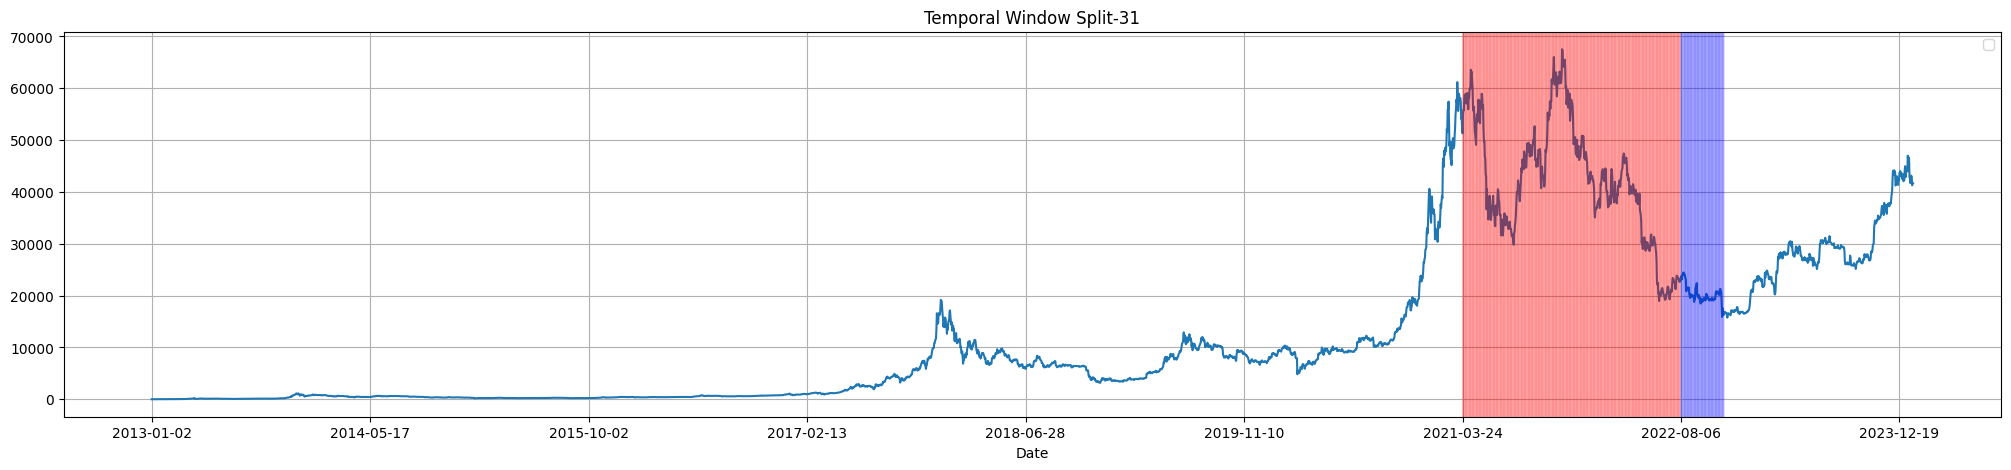

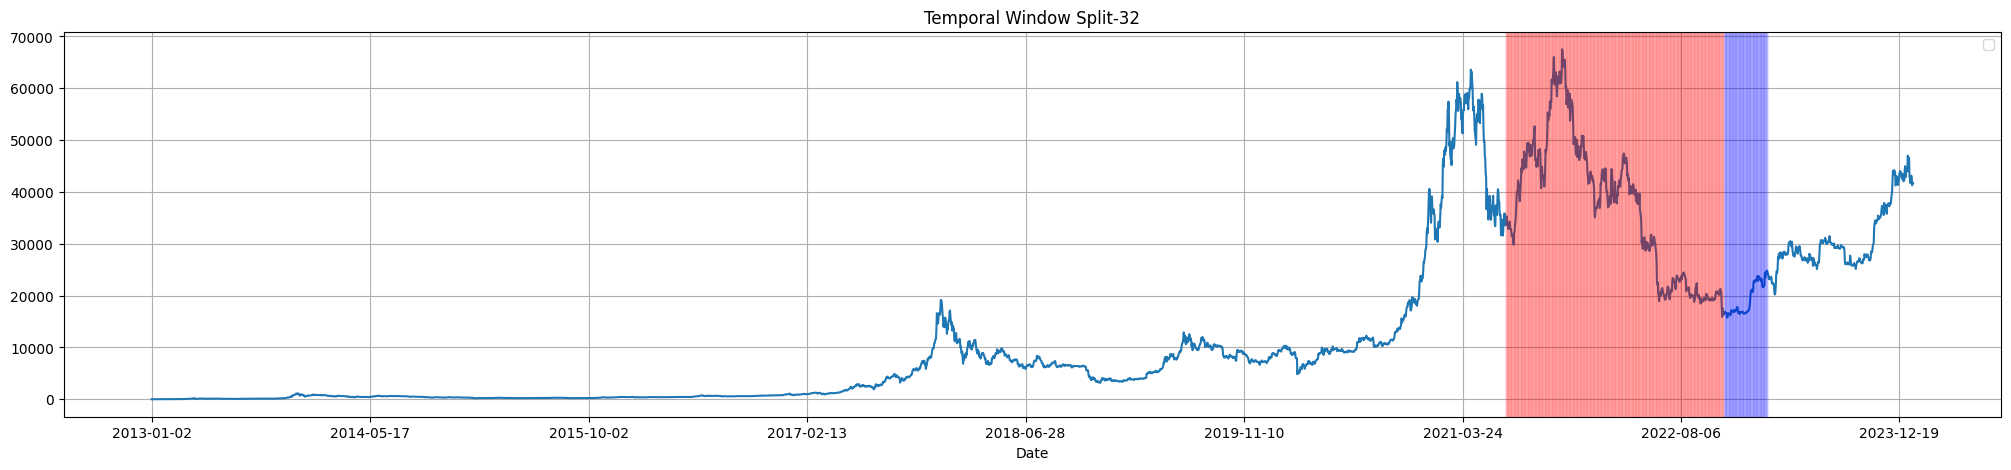

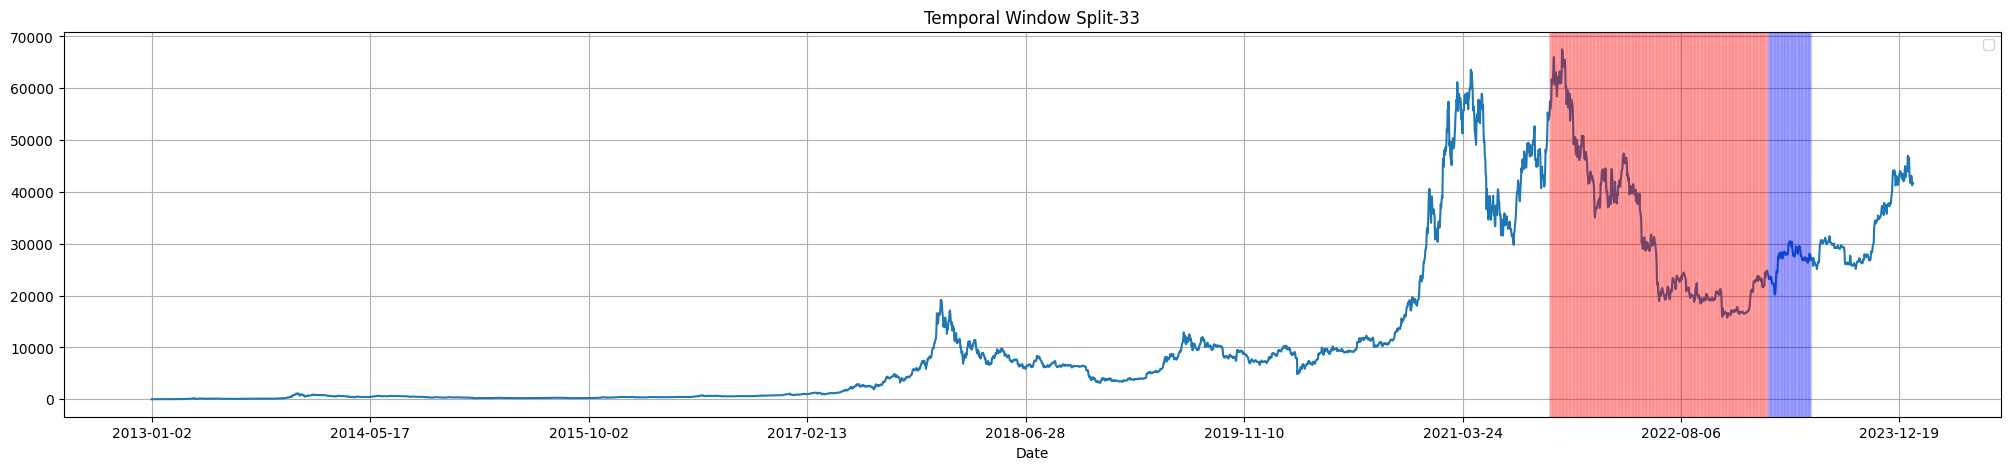

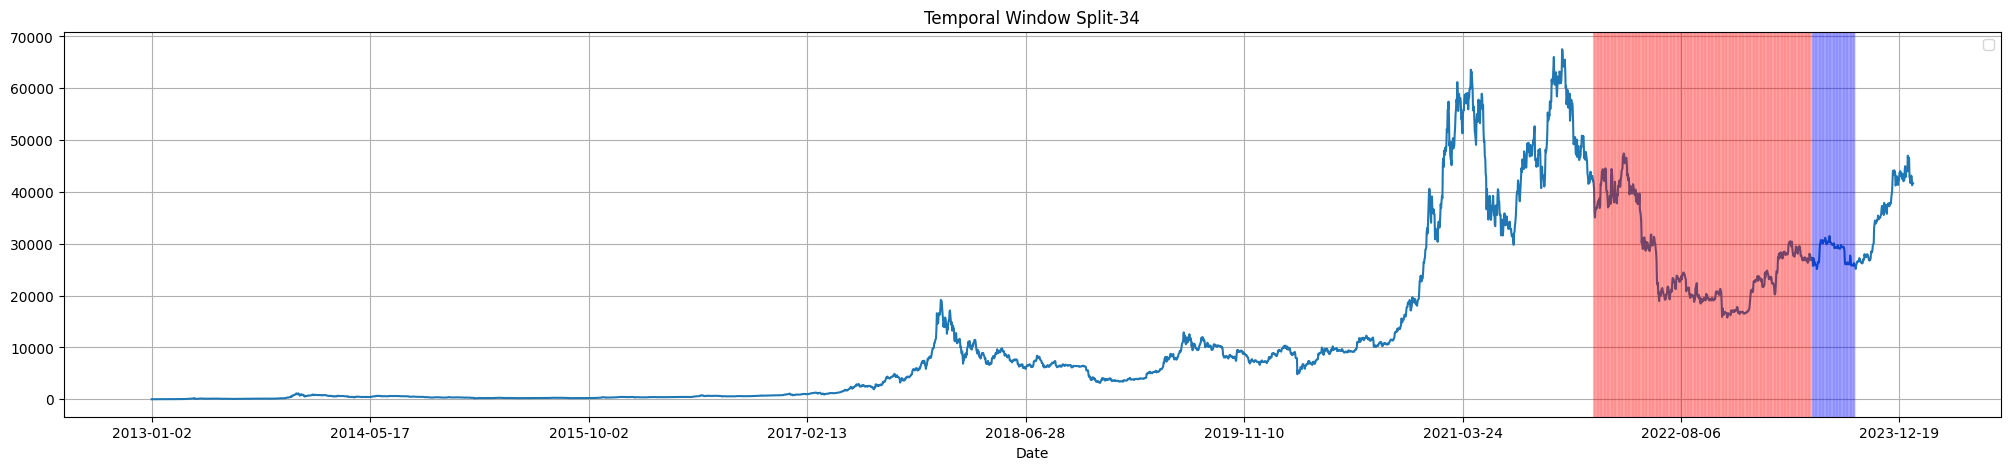

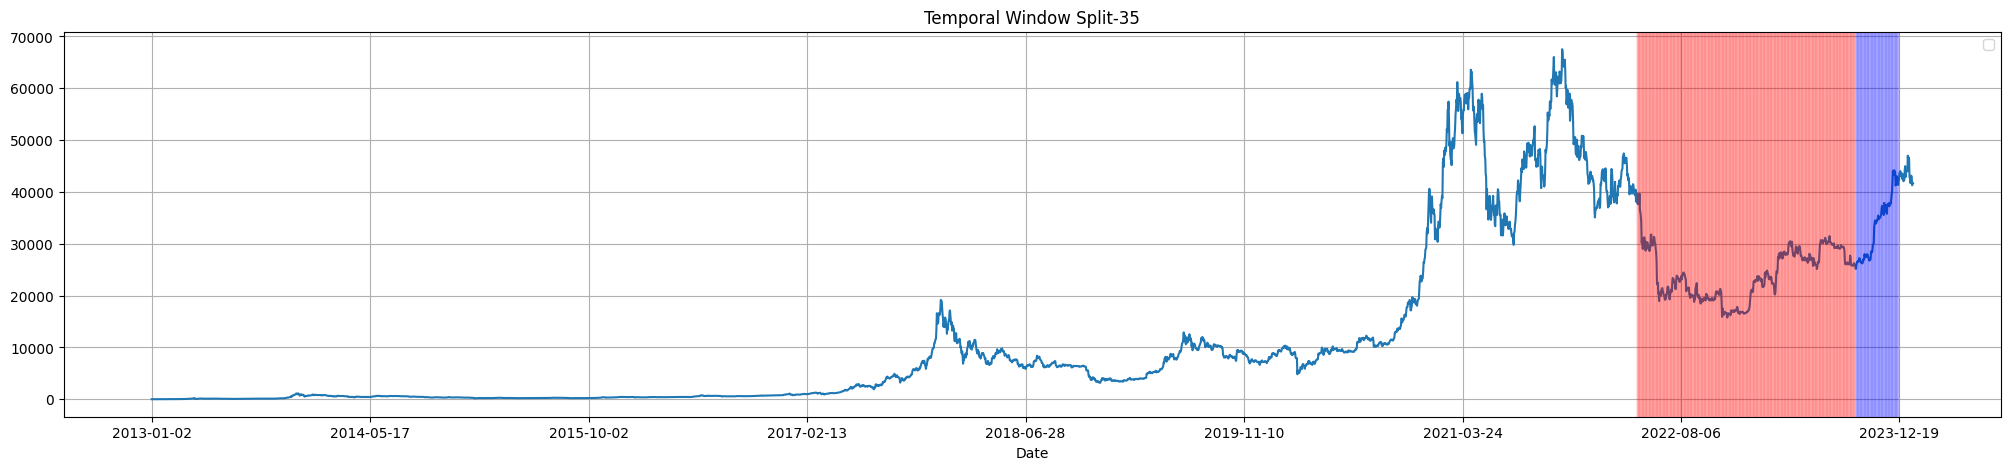

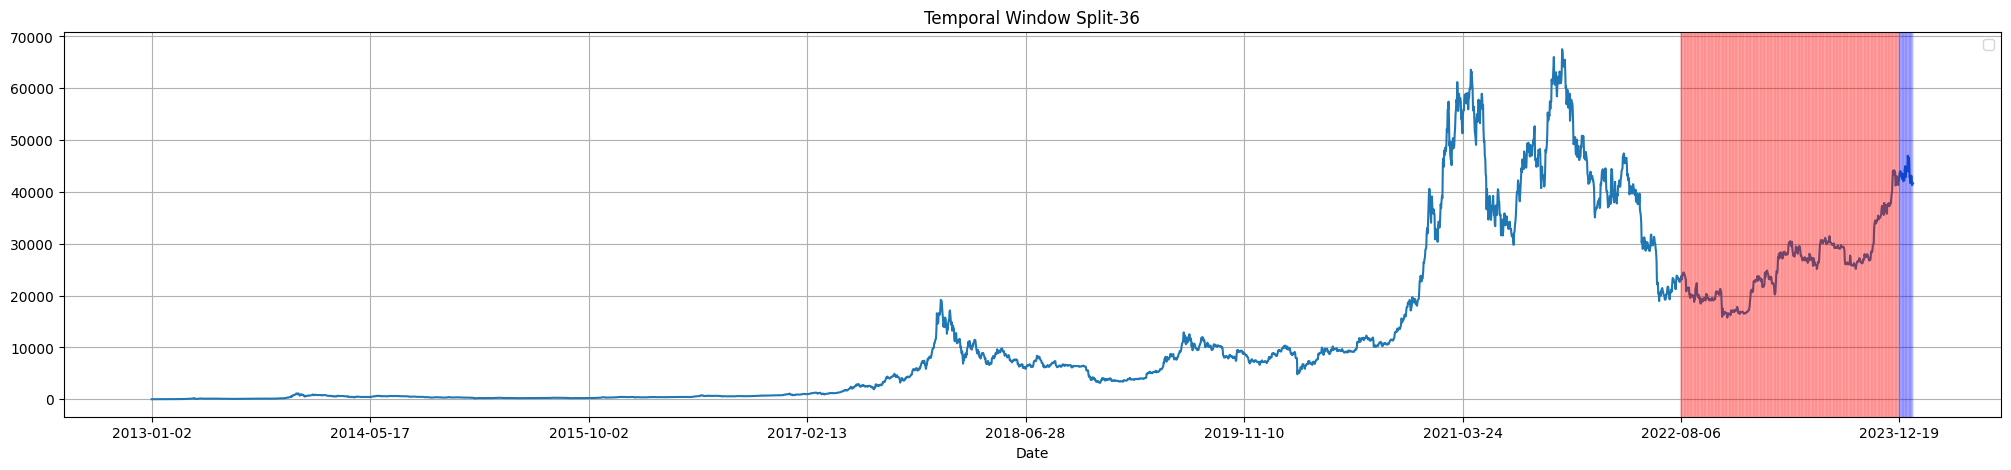

In [8]:
for i in range(len(train_splits)):
    visualize_split(i)

## Dummy Regressor

In [12]:
dmy_date_array = []
dmy_y_test_array = []
dmy_y_test_pred_array = []
dmy_batch_id_array = []
dmy_batch_id_array_result = []
dmy_batch_mae_train_array = []
dmy_batch_rmse_train_array = []
dmy_batch_mae_test_array = []
dmy_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    dmy = DummyRegressor(strategy="quantile",quantile=0.9)
    dmy.fit(Xtrain_split, ytrain_split)

    ytrain_pred = dmy.predict(Xtrain_split)
    ytest_pred = dmy.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    dmy_date_array.extend(test_splits[i]['Date'])
    dmy_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    dmy_y_test_pred_array.extend((ytest_pred.flatten()))
    dmy_batch_id_array.extend([i]*len(test_splits[i]))

    dmy_batch_id_array_result.append(i)
    dmy_batch_mae_train_array.append(MAE_train)
    dmy_batch_rmse_train_array.append(RMSE_train)

    dmy_batch_mae_test_array.append(MAE_test)
    dmy_batch_rmse_test_array.append(RMSE_test)

dmy_result_test_df = pd.DataFrame()
dmy_result_test_df['batch_id'] = dmy_batch_id_array
dmy_result_test_df['Date'] = dmy_date_array
dmy_result_test_df['y_test'] = dmy_y_test_array
dmy_result_test_df['y_test_pred'] = dmy_y_test_pred_array
dmy_y_test_array = dmy_result_test_df['y_test']
dmy_y_test_pred_array = dmy_result_test_df['y_test_pred']
dmy_result_metrics_df = pd.DataFrame()
dmy_result_metrics_df['batch_id'] = dmy_batch_id_array_result
dmy_result_metrics_df['mae_train'] = dmy_batch_mae_train_array
dmy_result_metrics_df['rmse_train'] = dmy_batch_rmse_train_array
dmy_result_metrics_df['mae_test'] = dmy_batch_mae_test_array
dmy_result_metrics_df['rmse_test'] = dmy_batch_rmse_test_array

100%|██████████| 36/36 [00:00<00:00, 582.70it/s]


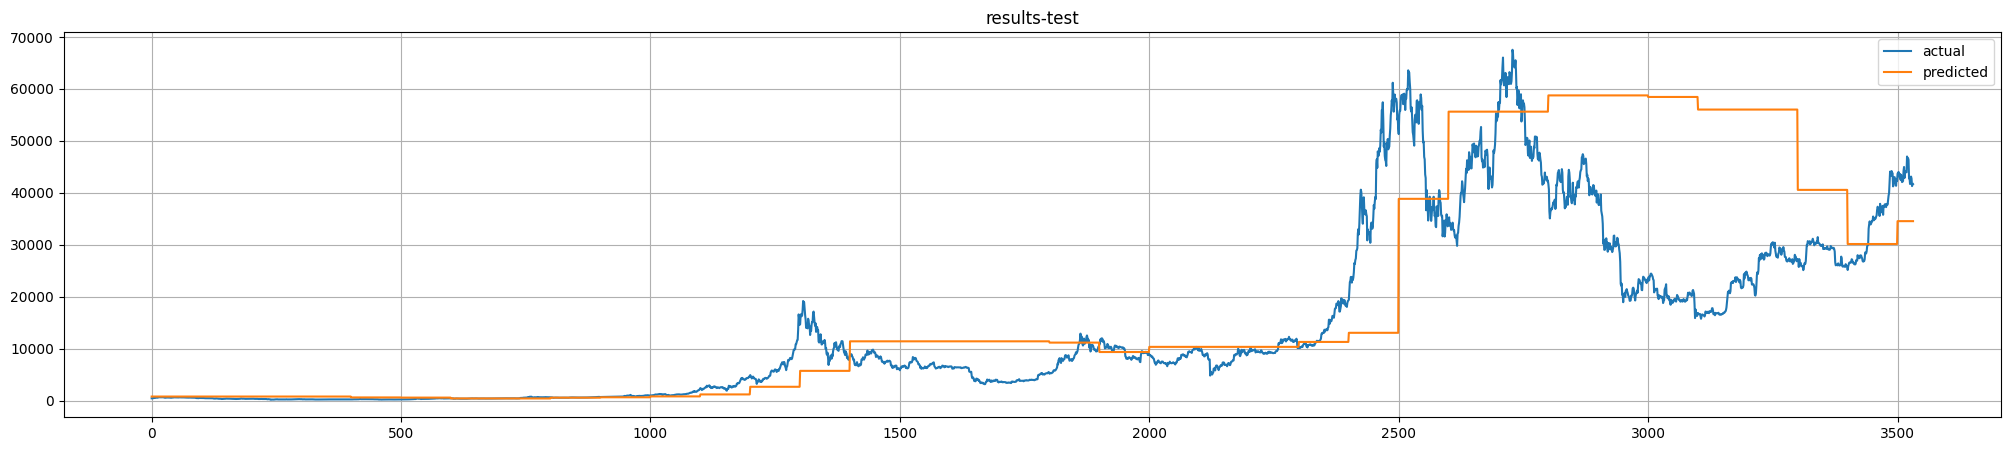

In [13]:
plot_results(dmy_y_test_array,dmy_y_test_pred_array,'results-test')

In [14]:
dmy_result_metrics_df

batch_id    mae_train    rmse_train      mae_test     rmse_test
0          0    506.51134    569.911393    207.472000    213.697716
1          1    398.30780    470.665792    395.814600    399.351249
2          2    339.99342    398.565711    519.451800    521.776460
3          3    309.27752    350.101639    555.552200    555.703249
4          4    220.85710    262.226287    368.536900    369.296495
5          5    246.69058    276.228229    234.859100    245.704702
6          6    131.90384    147.534756     22.131320     28.858968
7          7    119.85854    140.279475    145.185400    178.667621
8          8    229.64058    250.691384     38.344900     52.259751
9          9    217.34492    257.085749    196.747000    225.196006
10        10    288.00458    324.696679    468.716600    547.585258
11        11    512.56104    568.824788   1739.382300   1883.282872
12        12   1575.01788   1707.776242   3710.738100   4595.304345
13        13   3836.70474   4149.893147   6194.927200   6889.855030
14        14   7399.25364   8112.451525   3583.608600   3725.748874
15        15   6001.22416   6798.885696   4656.992500   4689.917504
16        16   4906.45478   5484.623933   6525.680900   6648.699456
17        17   4515.64822   4943.356246   7327.015600   7353.380465
18        18   4711.29344   5160.438946   2457.491600   3014.711604
19        19   3118.23764   3586.295415    986.991700   1147.048936
20        20   3678.19636   4292.908238   2153.385400   2381.261236
21        21   3391.17074   4114.135014   2452.813500   2811.529178
22        22   2790.29306   3496.669417   1028.028040   1081.274248
23        23   2435.76356   2847.527128   3126.769100   4255.208060
24        24   3855.36528   4189.399461  27897.587600  30097.241877
25        25  24981.90392  26380.907714  10582.103060  13134.013240
26        26  32124.23290  36362.160925  12507.682400  14134.101315
27        27  25081.04948  30104.405672   6848.884940   7739.431787
28        28  19557.52038  24799.193090  17776.971000  18005.994534
29        29  14158.16342  16634.664946  32800.393900  33266.213950
30        30  16908.37024  19984.870121  38236.929600  38276.073961
31        31  20138.14790  23353.070691  36741.417100  36865.087280
32        32  24904.41944  27841.924786  29104.342000  29205.614434
33        33  14451.43284  16273.847558  12237.000400  12383.570800
34        34   6366.02156   7751.660585   5795.625780   6804.205832
35        35   9722.29636  10889.247795   8943.736625   9060.168826

In [15]:
pd.DataFrame(dmy_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   7336.920367
rmse_train  8424.364616
mae_test    8015.814188
rmse_test   8410.751031

## Linear Regression

Linear model fitted by minimizing a regularized empirical loss with SGD.

SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).

In [57]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_mae_train_array = []
lr_batch_rmse_train_array = []
lr_batch_mae_test_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price', 'Date'], axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    sgd_reg  = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)
    
    pickle.dump(sgd_reg, open(f'LinearRegressionModel/linear_reg_10_{i}.sav', 'wb'))

    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    MAE_train, RMSE_train = calculate_metrics(ytrain_split, ytrain_pred)
    MAE_test, RMSE_test = calculate_metrics(ytest_split, ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_mae_train_array.append(MAE_train)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_mae_test_array.append(MAE_test)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['mae_train'] = lr_batch_mae_train_array
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['mae_test'] = lr_batch_mae_test_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:01<00:00, 28.70it/s]


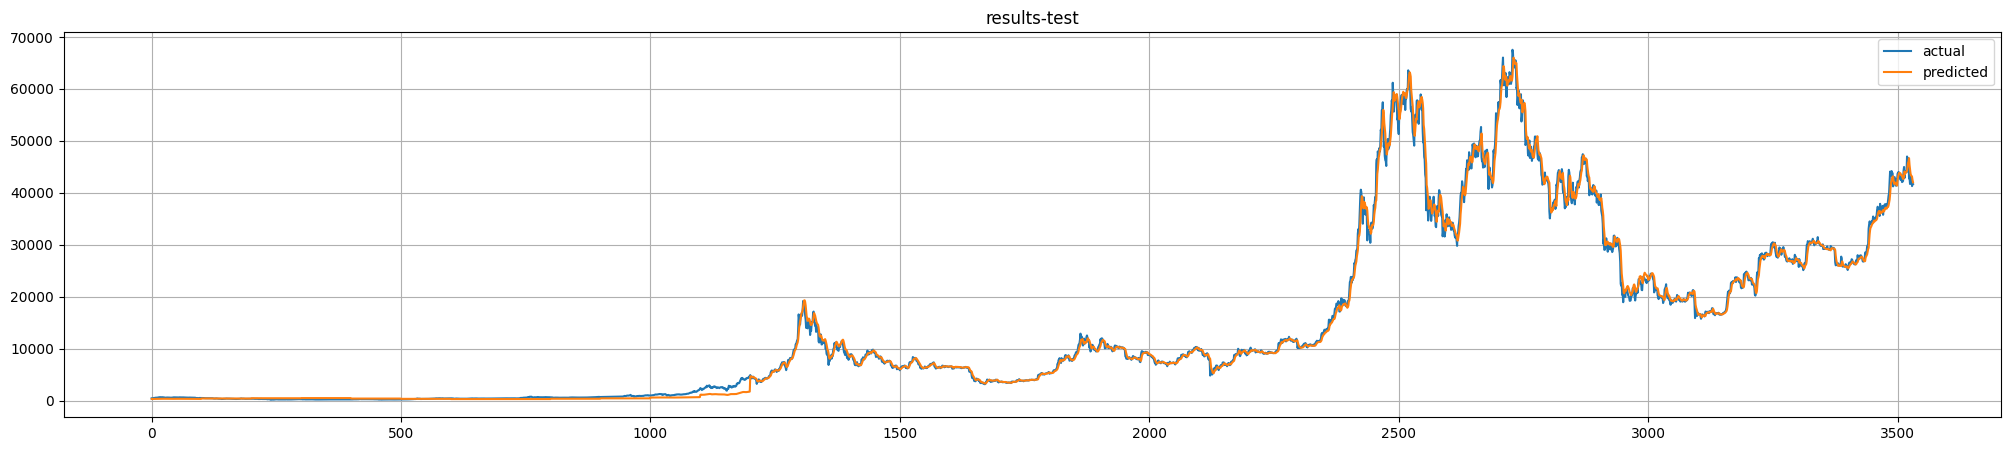

In [58]:
plot_results(lr_y_test_array,lr_y_test_pred_array,'results-test')

In [59]:
lr_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0   213.705207   240.866266   232.710813   236.647024
1          1   214.531896   238.657550    42.783410    47.902502
2          2   180.801564   224.403068   189.043321   194.903593
3          3   153.998282   187.427036   256.468666   256.780445
4          4   130.834226   148.296855   151.733999   153.542126
5          5   114.278116   136.209975    62.794266    71.818402
6          6    66.837906    77.702809   104.594674   106.546506
7          7    69.383007    77.359014   261.588790   281.478444
8          8   107.983522   131.326566   243.855491   246.772243
9          9   119.922456   144.850859   402.814782   417.120728
10        10   145.857338   174.616727   672.453439   721.734268
11        11   193.337189   251.797216  1628.552940  1718.155658
12        12    44.160299    78.048917   340.800392   586.740276
13        13   104.063226   230.097232   891.685958  1133.965113
14        14   246.603431   475.973234   262.273406   334.397693
15        15   284.325531   485.305970   180.653585   243.963482
16        16   312.569351   500.151721   162.156701   234.093296
17        17   324.500915   510.715922    84.132639   137.249449
18        18   278.961934   449.231604   441.610769   582.638461
19        19   225.189711   338.753371   300.878148   440.720600
20        20   232.920569   361.918670   221.343249   279.571913
21        21   240.076369   365.906405   378.897172   546.533588
22        22   287.334042   425.480577   213.289427   329.043967
23        23   302.996039   442.121684   513.915462   680.588464
24        24   296.160658   434.067294  2134.864043  2644.070240
25        25   635.452965  1197.499398  2125.869995  2706.626583
26        26   999.863181  1626.100712  1569.093377  2003.529892
27        27  1231.308759  1809.175533  1537.707022  2010.474864
28        28  1473.913678  1977.176100  1348.133238  1749.957545
29        29  1637.810280  2089.381090  1257.445279  1663.892187
30        30  1513.330228  1972.096295   567.834310   843.658575
31        31  1176.615558  1632.562636   370.415427   584.485863
32        32   988.690154  1465.240664   644.394213   894.116062
33        33   795.550742  1201.882056   414.899275   694.307005
34        34   609.819574   934.757256   858.223763  1173.261057
35        35   546.119343   818.578878  1027.350845  1366.079626

In [60]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   458.327979
rmse_train  662.659366
mae_test    613.812841
rmse_test   786.593548

## SVR

In [16]:
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_mae_train_array = []
svr_batch_rmse_train_array = []
svr_batch_mae_test_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)

    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_mae_train_array.append(MAE_train)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_mae_test_array.append(MAE_test)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['mae_train'] = svr_batch_mae_train_array
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['mae_test'] = svr_batch_mae_test_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████| 36/36 [00:01<00:00, 28.76it/s]


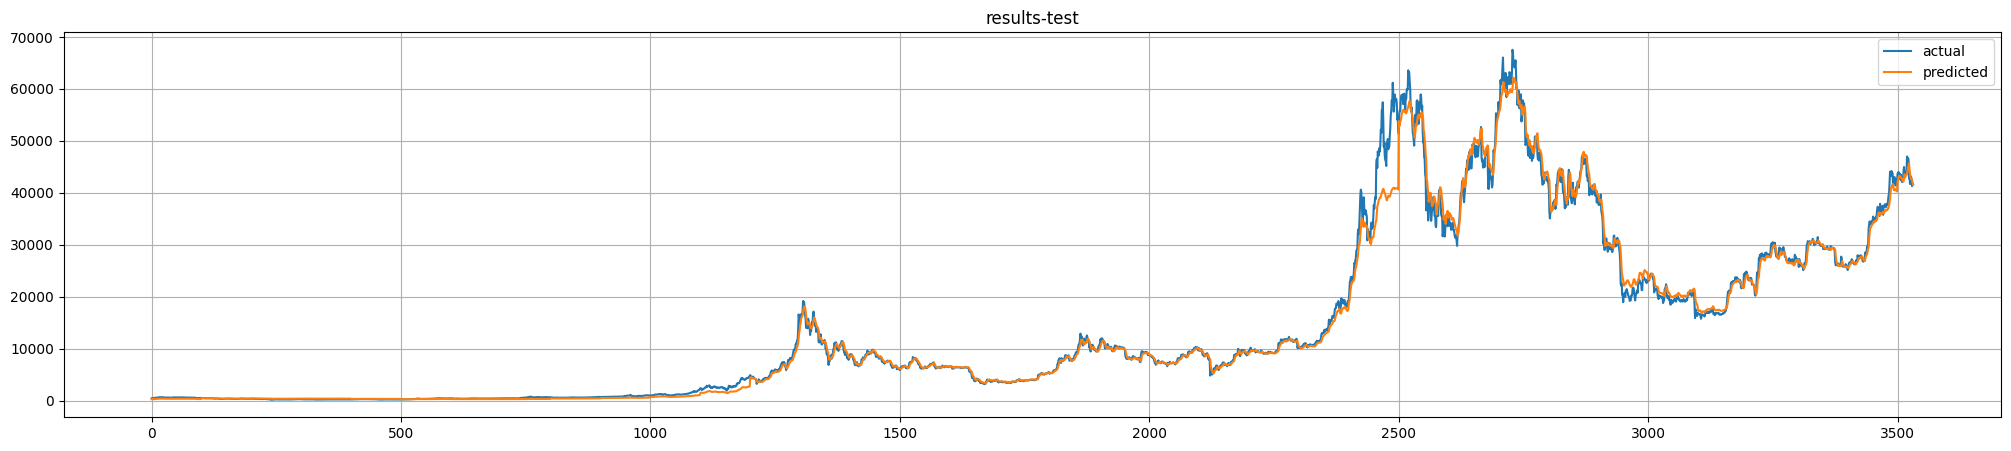

In [20]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

In [21]:
svr_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0   111.911909   170.349963   225.811985   227.687263
1          1   113.051612   130.681790    32.260845    36.793705
2          2   110.409582   138.517219   117.124379   120.882848
3          3   102.805466   128.510495   154.792171   155.043349
4          4    91.895316   106.887725    88.842088    90.465876
5          5    81.275806   114.528746    63.280458    76.082369
6          6    54.455045    70.922334   113.689862   115.103080
7          7    56.143357    71.088847   249.639248   265.073338
8          8    83.085135   101.249236   190.844875   193.235269
9          9    87.924259   108.021252   309.923235   320.778768
10        10   102.041479   122.873320   470.224620   507.758199
11        11   113.361325   165.113948  1065.038501  1126.376224
12        12    54.808116   102.621130   530.084643   817.334111
13        13    96.300693   254.336004   716.872862   888.961481
14        14   230.692010   457.731293   255.877457   328.359993
15        15   278.540936   480.209100   175.953953   238.380897
16        16   303.973726   491.336685   161.244928   229.345497
17        17   316.279826   504.574560   100.428546   139.165229
18        18   268.440990   438.461148   440.296784   579.639722
19        19   225.024613   337.845316   309.712574   446.968048
20        20   230.275729   358.445986   220.114744   283.484530
21        21   236.902397   364.410284   371.336189   535.195113
22        22   280.671330   420.535748   227.900593   339.847299
23        23   311.673965   449.249738   754.893814   958.843345
24        24   294.519426   432.999143  7085.973724  9027.797779
25        25   631.653002  1210.531210  2717.855780  3221.218860
26        26  1019.576347  1676.357220  1709.105484  2181.648986
27        27  1250.391056  1825.630236  1984.909640  2483.452523
28        28  1507.836668  2031.077008  1478.521643  1906.033143
29        29  1622.331506  2096.891996  1674.793929  2025.532253
30        30  1475.498192  1955.408475   943.420683  1149.511378
31        31  1199.728061  1670.670543   626.138401   749.818617
32        32  1008.265853  1463.656824   733.672159   990.713875
33        33   780.752148  1180.953028   409.009054   681.742746
34        34   585.685375   910.071628  1042.464709  1414.174591
35        35   524.194629   799.028184  1037.679167  1323.908494

In [22]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train    440.066025
rmse_train   648.382704
mae_test     799.714826
rmse_test   1004.898855

In [24]:
xgb_date_array = []
xgb_y_test_array = []
xgb_y_test_pred_array = []
xgb_batch_id_array = []
xgb_batch_id_array_result = []
xgb_batch_mae_train_array = []
xgb_batch_rmse_train_array = []
xgb_batch_mape_train_array = []
xgb_batch_mae_test_array = []
xgb_batch_rmse_test_array = []
xgb_batch_mape_test_array = []
for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    xgbm_reg = xgb.XGBRegressor(n_estimators=500,max_depth=3,objective='reg:squarederror',
                                learning_rate =0.01,n_jobs=-1)
    xgbm_reg.fit(Xtrain_split, ytrain_split)

    ytrain_pred = xgbm_reg.predict(Xtrain_split)
    ytest_pred = xgbm_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    xgb_date_array.extend(test_splits[i]['Date'])
    xgb_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    xgb_y_test_pred_array.extend((ytest_pred.flatten()))
    xgb_batch_id_array.extend([i]*len(test_splits[i]))

    xgb_batch_id_array_result.append(i)
    xgb_batch_mae_train_array.append(MAE_train)
    xgb_batch_rmse_train_array.append(RMSE_train)
    xgb_batch_mae_test_array.append(MAE_test)
    xgb_batch_rmse_test_array.append(RMSE_test)

xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['batch_id'] = xgb_batch_id_array
xgb_result_test_df['Date'] = xgb_date_array
xgb_result_test_df['y_test'] = xgb_y_test_array
xgb_result_test_df['y_test_pred'] = xgb_y_test_pred_array
xgb_y_test_array = xgb_result_test_df['y_test']
xgb_y_test_pred_array = xgb_result_test_df['y_test_pred']
xgb_result_metrics_df = pd.DataFrame()
xgb_result_metrics_df['batch_id'] = xgb_batch_id_array_result
xgb_result_metrics_df['mae_train'] = xgb_batch_mae_train_array
xgb_result_metrics_df['rmse_train'] = xgb_batch_rmse_train_array
xgb_result_metrics_df['mae_test'] = xgb_batch_mae_test_array
xgb_result_metrics_df['rmse_test'] = xgb_batch_rmse_test_array

100%|██████████| 36/36 [00:05<00:00,  6.58it/s]


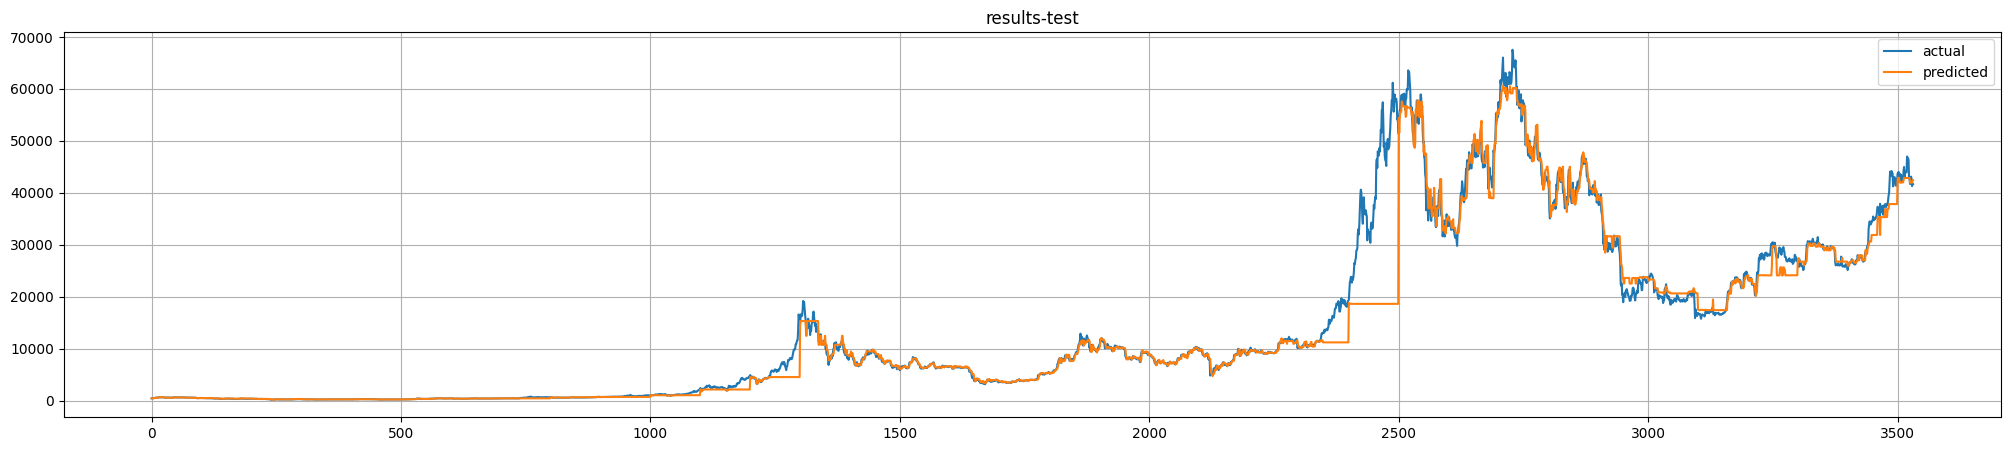

In [25]:
plot_results(xgb_y_test_array,xgb_y_test_pred_array,'results-test')

In [26]:
xgb_result_metrics_df

batch_id    mae_train   rmse_train      mae_test     rmse_test
0          0    10.668795    19.981659     22.796768     27.640627
1          1    12.666786    21.745973     34.410754     38.953329
2          2    13.741192    22.315900     24.505391     30.632128
3          3    14.732593    22.567386     10.138447     11.920558
4          4     8.796064    13.467671      4.323065      5.737204
5          5     6.266781     9.108597     11.225421     16.621174
6          6     5.405348     7.587116      6.228916      9.540991
7          7     4.357201     6.015273    121.594666    159.004320
8          8     4.052808     5.742804     23.191601     29.136625
9          9     4.310328     6.226558    132.471407    169.178376
10        10     5.477623     8.142328    253.837843    371.411830
11        11     8.251131    13.747441    806.803713   1071.314287
12        12    19.001525    32.038479   2042.367898   3261.727123
13        13    49.994536   114.709108    894.541905   1171.804032
14        14   111.937463   186.704081    257.203847    322.760947
15        15   137.270055   199.904307    129.033222    170.539581
16        16   146.796673   206.865769    184.351970    254.139492
17        17   151.524079   208.857300     82.996142    134.455719
18        18   130.649023   188.274707    397.686229    538.557510
19        19   120.402402   177.259105    261.035046    376.015642
20        20   130.258301   198.017133    212.173971    268.617170
21        21   142.598232   213.100372    313.261492    510.560044
22        22   173.611072   258.512122    233.607995    341.127437
23        23   196.297497   277.968102   3016.750849   4292.931925
24        24   188.947122   281.300937  22322.612741  25020.026939
25        25   331.557946   563.537913   2392.042336   3016.637789
26        26   637.463634  1005.555574   1811.443738   2457.107650
27        27   844.356590  1243.201555   2089.017894   2628.906517
28        28  1051.610165  1424.572581   1341.802866   1768.781404
29        29  1178.309984  1529.382835   1936.474265   2302.190973
30        30  1033.618131  1353.593700   1181.700116   1489.171219
31        31   849.916856  1156.166952    635.455150    775.439820
32        32   646.571807   905.697614   2685.244117   3079.541465
33        33   517.581889   728.538726    576.010532    754.867311
34        34   396.586714   570.957180   1992.223333   2699.411676
35        35   341.881714   506.257603   1205.852329   1614.052094

In [27]:
pd.DataFrame(xgb_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train    267.429724
rmse_train   380.211735
mae_test    1379.067166
rmse_test   1699.735081

## LSTM

Callbacks

EarlyStopping has a callback that is commonly used during training neural networks to stop the training process early if a certain condition is met  
This way, the training process will monitor the specified metric ('root_mean_squared_error' in this case) and stop early if the conditions specified by min_delta and patience are met.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

Learning Rate Scheduler

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [21]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [22]:
callback_list=[reduce_lr,lrschedule,earlystop]

Build the model

In [23]:
# Define the input layer with a shape of (1, 10)
input_layer = Input(shape=(1, 10),name='input_layer')
# First LSTM layer with 400 units, returning sequences, and using ReLU activation
lstm_1 = LSTM(400, return_sequences=True,activation='relu',name='lstm_1')(input_layer)
# Dropout layer with a dropout rate of 0.25
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
# Second LSTM layer with 500 units, returning sequences, and using ReLU activation
lstm_2 = LSTM(500, return_sequences=True,activation='relu',name='lstm_2')(dropout_1)
# Dropout layer with a dropout rate of 0.3
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)
# Output layer with a single unit (Dense layer)
output_layer = Dense(1,name='output_layer')(dropout_2)
# Create the model with input and output layers
model=Model(inputs=input_layer,outputs=output_layer)
# Adam optimizer with specific parameters
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
# Compile the model with log_cosh loss function and additional metrics (RootMeanSquaredError and Mean Absolute Error)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 10)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 400)            657600    
                                                                 
 dropout_1 (Dropout)         (None, 1, 400)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 500)            1802000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 500)            0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              501       
                                                                 
Total params: 2460101 (9.38 MB)
Trainable params: 2460101 (

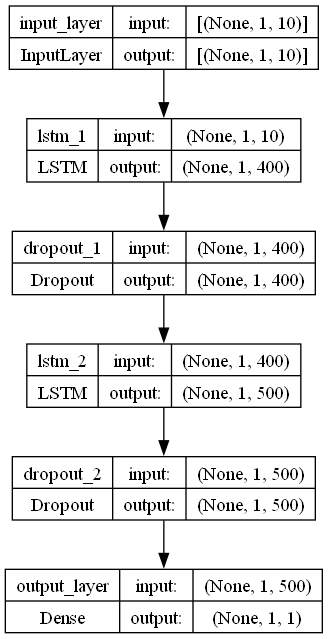

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [26]:
lstm_date_array = []
lstm_y_test_array = []
lstm_y_test_pred_array = []
lstm_batch_id_array = []
lstm_batch_id_array_result = []
lstm_batch_mae_train_array = []
lstm_batch_rmse_train_array = []
lstm_batch_mae_test_array = []
lstm_batch_rmse_test_array = []
from keras import backend as K 

for i in range(len(train_splits)):
#     print(f'Batch No. {i+1} of {len(train_splits)}')
#     print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
#           'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
#     print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
#           'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    model.save(f'LSTM/lstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lstm_date_array.extend(test_splits[i]['Date'])
    lstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lstm_y_test_pred_array.extend((ytest_pred.flatten()))
    lstm_batch_id_array.extend([i]*len(test_splits[i]))

    lstm_batch_id_array_result.append(i)
    lstm_batch_mae_train_array.append(MAE_train)
    lstm_batch_rmse_train_array.append(RMSE_train)
    lstm_batch_mae_test_array.append(MAE_test)
    lstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

lstm_result_test_df = pd.DataFrame()
lstm_result_test_df['batch_id'] = lstm_batch_id_array
lstm_result_test_df['Date'] = lstm_date_array
lstm_result_test_df['y_test'] = lstm_y_test_array
lstm_result_test_df['y_test_pred'] = lstm_y_test_pred_array
lstm_y_test_array = lstm_result_test_df['y_test']
lstm_y_test_pred_array = lstm_result_test_df['y_test_pred']

lstm_result_metrics_df = pd.DataFrame()
lstm_result_metrics_df['batch_id'] = lstm_batch_id_array_result
lstm_result_metrics_df['mae_train'] = lstm_batch_mae_train_array
lstm_result_metrics_df['rmse_train'] = lstm_batch_rmse_train_array
lstm_result_metrics_df['mae_test'] = lstm_batch_mae_test_array
lstm_result_metrics_df['rmse_test'] = lstm_batch_rmse_test_array


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 303.7232 - root_mean_squared_error: 418.8556 - mae: 304.2232 - lr: 0.0010 - 2s/epoch - 144ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 303.4987 - root_mean_squared_error: 420.5527 - mae: 303.9987 - lr: 0.0010 - 286ms/epoch - 18ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 302.8442 - root_mean_squared_error: 420.7428 - mae: 303.3442 - lr: 0.0010 - 282ms/epoch - 18ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 301.0409 - root_mean_squared_error: 418.9086 - mae: 301.5409 - lr: 9.8000e-04 - 280ms/epoch - 17ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0009604000113904476.
Epoch 5/500
1

INFO:tensorflow:Assets written to: /LSTM/lstm_1\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 293.5555 - root_mean_squared_error: 384.6534 - mae: 294.0547 - lr: 0.0010 - 3s/epoch - 159ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 279.4435 - root_mean_squared_error: 343.5402 - mae: 279.9434 - lr: 0.0010 - 325ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 265.4877 - root_mean_squared_error: 300.0677 - mae: 265.9877 - lr: 0.0010 - 343ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 248.2501 - root_mean_squared_error: 276.7478 - mae: 248.7499 - lr: 0.0010 - 337ms/epoch - 21ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_2\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 189.3979 - root_mean_squared_error: 235.1351 - mae: 189.8971 - lr: 0.0010 - 3s/epoch - 174ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 188.9351 - root_mean_squared_error: 234.8716 - mae: 189.4346 - lr: 0.0010 - 327ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 188.8441 - root_mean_squared_error: 234.7744 - mae: 189.3435 - lr: 0.0010 - 338ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 189.1884 - root_mean_squared_error: 235.3701 - mae: 189.6876 - lr: 0.0010 - 328ms/epoch - 21ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_3\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 157.8454 - root_mean_squared_error: 194.8216 - mae: 158.3448 - lr: 0.0010 - 2s/epoch - 149ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 157.6138 - root_mean_squared_error: 194.9059 - mae: 158.1130 - lr: 0.0010 - 320ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 157.7600 - root_mean_squared_error: 195.6642 - mae: 158.2595 - lr: 0.0010 - 316ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 158.0192 - root_mean_squared_error: 195.8589 

INFO:tensorflow:Assets written to: /LSTM/lstm_4\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 140.4994 - root_mean_squared_error: 160.7625 - mae: 140.9988 - lr: 0.0010 - 2s/epoch - 150ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 131.0124 - root_mean_squared_error: 151.7748 - mae: 131.5117 - lr: 0.0010 - 324ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 131.4837 - root_mean_squared_error: 154.3128 - mae: 131.9829 - lr: 0.0010 - 319ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 131.4886 - root_mean_squared_error: 153.5769 - mae: 131.9879 - lr: 0.0010 - 318ms/epoch - 20ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_5\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 118.9017 - root_mean_squared_error: 140.4165 - mae: 119.4011 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 108.2859 - root_mean_squared_error: 145.9068 - mae: 108.7851 - lr: 0.0010 - 331ms/epoch - 21ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 108.3179 - root_mean_squared_error: 154.9574 - mae: 108.8167 - lr: 0.0010 - 316ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 108.1424 - root_mean_squared_error: 154.2986 

INFO:tensorflow:Assets written to: /LSTM/lstm_6\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 64.1320 - root_mean_squared_error: 82.0718 - mae: 64.6307 - lr: 0.0010 - 3s/epoch - 190ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 64.8626 - root_mean_squared_error: 86.5131 - mae: 65.3611 - lr: 0.0010 - 320ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 64.4247 - root_mean_squared_error: 84.0446 - mae: 64.9233 - lr: 0.0010 - 321ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 64.2024 - root_mean_squared_error: 83.7654 - mae: 64.7

INFO:tensorflow:Assets written to: /LSTM/lstm_7\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 66.3091 - root_mean_squared_error: 83.5152 - mae: 66.8076 - lr: 0.0010 - 2s/epoch - 150ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 66.4088 - root_mean_squared_error: 84.8401 - mae: 66.9072 - lr: 0.0010 - 301ms/epoch - 19ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 66.4735 - root_mean_squared_error: 84.9905 - mae: 66.9719 - lr: 0.0010 - 290ms/epoch - 18ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 66.7064 - root_mean_squared_error: 83.9499 - mae: 67.2

INFO:tensorflow:Assets written to: /LSTM/lstm_8\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 113.7079 - root_mean_squared_error: 153.8354 - mae: 114.2072 - lr: 0.0010 - 3s/epoch - 166ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 110.2227 - root_mean_squared_error: 141.0137 - mae: 110.7223 - lr: 0.0010 - 357ms/epoch - 22ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 109.4186 - root_mean_squared_error: 135.2805 - mae: 109.9181 - lr: 0.0010 - 398ms/epoch - 25ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 109.4264 - root_mean_squared_error: 134.9511 - mae: 109.9262 - lr: 0.0010 - 390ms/epoch - 24ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_9\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 130.2197 - root_mean_squared_error: 162.1713 - mae: 130.7188 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 123.4989 - root_mean_squared_error: 148.9747 - mae: 123.9975 - lr: 0.0010 - 309ms/epoch - 19ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 122.3588 - root_mean_squared_error: 149.0244 - mae: 122.8576 - lr: 0.0010 - 307ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 122.8938 - root_mean_squared_error: 150.0130 - mae: 123.3927 - lr: 0.0010 - 327ms/epoch - 20ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_10\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 166.0114 - root_mean_squared_error: 217.6609 - mae: 166.5108 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 159.5432 - root_mean_squared_error: 196.3696 - mae: 160.0430 - lr: 0.0010 - 284ms/epoch - 18ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 159.4255 - root_mean_squared_error: 194.0250 - mae: 159.9252 - lr: 0.0010 - 283ms/epoch - 18ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 159.6268 - root_mean_squared_error: 194.2659 - mae: 160.1265 - lr: 0.0010 - 296ms/epoch - 18ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_11\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 258.6459 - root_mean_squared_error: 376.6175 - mae: 259.1452 - lr: 0.0010 - 3s/epoch - 199ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 249.1700 - root_mean_squared_error: 351.3975 - mae: 249.6694 - lr: 0.0010 - 330ms/epoch - 21ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 248.9765 - root_mean_squared_error: 353.1983 - mae: 249.4760 - lr: 0.0010 - 310ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 249.3885 - root_mean_squared_error: 357.8984 - mae: 249.8879 - lr: 0.0010 - 313ms/epoch - 20ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: /LSTM/lstm_12\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 643.4684 - root_mean_squared_error: 1083.5566 - mae: 643.9681 - lr: 0.0010 - 3s/epoch - 158ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 631.4597 - root_mean_squared_error: 1045.2566 - mae: 631.9594 - lr: 0.0010 - 324ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 630.3618 - root_mean_squared_error: 1037.9170 - mae: 630.8616 - lr: 0.0010 - 326ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 630.3787 - root_mean_squared_error: 1029.4147 - mae: 630.8786 - lr: 0.0010 - 334ms/epoch - 21ms/step

Epoch 5: Learning

INFO:tensorflow:Assets written to: /LSTM/lstm_13\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1659.8289 - root_mean_squared_error: 2908.5544 - mae: 1660.3289 - lr: 0.0010 - 2s/epoch - 151ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1618.5039 - root_mean_squared_error: 2735.2197 - mae: 1619.0038 - lr: 0.0010 - 324ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1615.2118 - root_mean_squared_error: 2754.1479 - mae: 1615.7115 - lr: 0.0010 - 324ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1614.8298 - root_mean_squared_error: 2737.1667 - mae: 1615.3296 - lr: 0.0010 - 312ms/epoch - 19ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_14\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 3596.6455 - root_mean_squared_error: 5575.1196 - mae: 3597.1453 - lr: 0.0010 - 2s/epoch - 149ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 3479.9084 - root_mean_squared_error: 5384.9717 - mae: 3480.4084 - lr: 0.0010 - 347ms/epoch - 22ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 3385.7144 - root_mean_squared_error: 5102.8179 - mae: 3386.2144 - lr: 0.0010 - 344ms/epoch - 22ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 3362.1731 - root_mean_squared_error: 4948.0225 - mae: 3362.6731 - lr: 0.0010 - 347ms/epoch - 22ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_15\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 3943.8757 - root_mean_squared_error: 5290.6665 - mae: 3944.3757 - lr: 0.0010 - 2s/epoch - 150ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 3704.9790 - root_mean_squared_error: 4853.1909 - mae: 3705.4790 - lr: 0.0010 - 320ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 3549.6970 - root_mean_squared_error: 4487.8340 - mae: 3550.1970 - lr: 0.0010 - 316ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 3517.7087 - root_mean_squared_error: 4349.2236 - mae: 3518.2087 - lr: 0.0010 - 320ms/epoch - 20ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_16\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2728.3008 - root_mean_squared_error: 3663.8325 - mae: 2728.8008 - lr: 0.0010 - 2s/epoch - 139ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2616.1130 - root_mean_squared_error: 3524.5957 - mae: 2616.6130 - lr: 0.0010 - 300ms/epoch - 19ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2608.1516 - root_mean_squared_error: 3508.4067 - mae: 2608.6514 - lr: 0.0010 - 295ms/epoch - 18ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2606.3037 - root_mean_squared_error: 3530.3662 - mae: 2606.8037 - lr: 0.0010 - 293ms/epoch - 18ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_17\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2198.9133 - root_mean_squared_error: 3198.7646 - mae: 2199.4131 - lr: 0.0010 - 2s/epoch - 147ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2198.4568 - root_mean_squared_error: 3190.5627 - mae: 2198.9568 - lr: 0.0010 - 311ms/epoch - 19ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2199.0876 - root_mean_squared_error: 3193.3782 - mae: 2199.5876 - lr: 0.0010 - 309ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2195.2268 - root_mean_squared_error: 3182.6057 - mae: 2195.7266 - lr: 0.0010 - 315ms/epoch - 20ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_18\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2309.7839 - root_mean_squared_error: 3221.2168 - mae: 2310.2839 - lr: 0.0010 - 2s/epoch - 146ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2296.6836 - root_mean_squared_error: 3255.6069 - mae: 2297.1836 - lr: 0.0010 - 322ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2295.9553 - root_mean_squared_error: 3241.8525 - mae: 2296.4553 - lr: 0.0010 - 325ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 2290.3733 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /LSTM/lstm_19\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1751.3022 - root_mean_squared_error: 2198.1956 - mae: 1751.8022 - lr: 0.0010 - 2s/epoch - 144ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1747.1763 - root_mean_squared_error: 2195.4512 - mae: 1747.6763 - lr: 0.0010 - 313ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1747.6566 - root_mean_squared_error: 2185.8635 - mae: 1748.1566 - lr: 0.0010 - 320ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1748.5251 - root_mean_squared_error: 2206.7219 - mae: 1749.0249 - lr: 0.0010 - 319ms/epoch - 20ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_20\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2066.2617 - root_mean_squared_error: 2516.9558 - mae: 2066.7617 - lr: 0.0010 - 2s/epoch - 156ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2069.7947 - root_mean_squared_error: 2503.7637 - mae: 2070.2947 - lr: 0.0010 - 341ms/epoch - 21ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2074.4341 - root_mean_squared_error: 2521.0151 - mae: 2074.9341 - lr: 0.0010 - 336ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2064.4265 - root_mean_squared_error: 2506.3396 - mae: 2064.9265 - lr: 0.0010 - 331ms/epoch - 21ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_21\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 2261.5305 - root_mean_squared_error: 2617.0784 - mae: 2262.0305 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 2219.5813 - root_mean_squared_error: 2585.9282 - mae: 2220.0813 - lr: 0.0010 - 356ms/epoch - 22ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 2221.6658 - root_mean_squared_error: 2604.3887 - mae: 2222.1655 - lr: 0.0010 - 333ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 2210.2607 - root_mean_squared_error: 2579.0845 - mae: 2210.7607 - lr: 0.0010 - 334ms/epoch - 21ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_22\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1938.5935 - root_mean_squared_error: 2346.2344 - mae: 1939.0935 - lr: 0.0010 - 2s/epoch - 145ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1923.3953 - root_mean_squared_error: 2409.4797 - mae: 1923.8953 - lr: 0.0010 - 331ms/epoch - 21ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1909.7107 - root_mean_squared_error: 2396.3079 - mae: 1910.2107 - lr: 0.0010 - 319ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 1909.6122 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /LSTM/lstm_23\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1447.1782 - root_mean_squared_error: 1783.3263 - mae: 1447.6782 - lr: 0.0010 - 2s/epoch - 153ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1364.2510 - root_mean_squared_error: 1703.5923 - mae: 1364.7510 - lr: 0.0010 - 318ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1352.3739 - root_mean_squared_error: 1692.4113 - mae: 1352.8738 - lr: 0.0010 - 315ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1360.0719 - root_mean_squared_error: 1690.7534 - mae: 1360.5719 - lr: 0.0010 - 314ms/epoch - 20ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_24\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 1995.2646 - root_mean_squared_error: 2990.9746 - mae: 1995.7646 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 1980.8761 - root_mean_squared_error: 2931.5063 - mae: 1981.3760 - lr: 0.0010 - 339ms/epoch - 21ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 1971.5686 - root_mean_squared_error: 2933.2385 - mae: 1972.0685 - lr: 0.0010 - 315ms/epoch - 20ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 1970.1327 - root_mean_squared_error: 2938.5876 - mae: 1970.6327 - lr: 0.0010 - 313ms/epoch - 20ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_25\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 8032.5029 - root_mean_squared_error: 15070.8848 - mae: 8033.0029 - lr: 0.0010 - 3s/epoch - 166ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 8017.9639 - root_mean_squared_error: 14861.0195 - mae: 8018.4639 - lr: 0.0010 - 322ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 8007.5352 - root_mean_squared_error: 14908.4229 - mae: 8008.0352 - lr: 0.0010 - 355ms/epoch - 22ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 8002.5381 - root_mean_squared_error: 14931.0498 - mae: 8003.0381 - lr: 0.0010 - 316ms/epoch - 20ms/step

Epoch

INFO:tensorflow:Assets written to: /LSTM/lstm_26\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 14761.4775 - root_mean_squared_error: 22124.6934 - mae: 14761.9775 - lr: 0.0010 - 2s/epoch - 154ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 14523.4873 - root_mean_squared_error: 21157.7480 - mae: 14523.9873 - lr: 0.0010 - 354ms/epoch - 22ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 14548.5127 - root_mean_squared_error: 20700.4688 - mae: 14549.0127 - lr: 0.0010 - 333ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 14549.4170 - root_mean_squared_error: 20709.6973 - mae: 14549.9170 - lr: 0.0010 - 338ms/epoch - 21ms/ste

INFO:tensorflow:Assets written to: /LSTM/lstm_27\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 18660.2773 - root_mean_squared_error: 23447.4355 - mae: 18660.7773 - lr: 0.0010 - 2s/epoch - 144ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 17245.4512 - root_mean_squared_error: 20366.7832 - mae: 17245.9512 - lr: 0.0010 - 311ms/epoch - 19ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 16122.0391 - root_mean_squared_error: 18840.8887 - mae: 16122.5391 - lr: 0.0010 - 312ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 16312.2822 - root_mean_squared_error: 19039.0840 - mae: 16312.7822 - lr: 0.0010 - 315ms/epoch - 20ms/ste

INFO:tensorflow:Assets written to: /LSTM/lstm_28\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 3s - loss: 14181.1738 - root_mean_squared_error: 16646.6406 - mae: 14181.6738 - lr: 0.0010 - 3s/epoch - 162ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 13468.2246 - root_mean_squared_error: 16805.3359 - mae: 13468.7246 - lr: 0.0010 - 388ms/epoch - 24ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 13426.2188 - root_mean_squared_error: 16449.3066 - mae: 13426.7188 - lr: 0.0010 - 342ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 13419.5029 - root_mean_squared_error: 16365.9639 - mae: 13420.0029 - lr: 0.0010 - 356ms/epoch - 22ms/ste

INFO:tensorflow:Assets written to: /LSTM/lstm_29\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 8194.8691 - root_mean_squared_error: 10128.0312 - mae: 8195.3691 - lr: 0.0010 - 4s/epoch - 230ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 8175.3569 - root_mean_squared_error: 9989.3066 - mae: 8175.8569 - lr: 0.0010 - 326ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 8188.0815 - root_mean_squared_error: 10063.1064 - mae: 8188.5815 - lr: 0.0010 - 393ms/epoch - 25ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 8215.1484 - root_mean_squared_error: 10032.4512 - mae: 8215.6484 - lr: 0.0010 - 374ms/epoch - 23ms/step

Epoch 

INFO:tensorflow:Assets written to: /LSTM/lstm_30\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 9659.5332 - root_mean_squared_error: 11992.8633 - mae: 9660.0332 - lr: 0.0010 - 2s/epoch - 145ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 9596.2715 - root_mean_squared_error: 11954.4746 - mae: 9596.7715 - lr: 0.0010 - 349ms/epoch - 22ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 9630.9229 - root_mean_squared_error: 11939.7021 - mae: 9631.4229 - lr: 0.0010 - 336ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 9594.6240 - root_mean_squared_error: 11908.4209 - mae: 9595.1240 - lr: 0.0010 - 338ms/epoch - 21ms/step

Epoch

INFO:tensorflow:Assets written to: /LSTM/lstm_31\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 11609.1523 - root_mean_squared_error: 14097.0498 - mae: 11609.6523 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 11460.2988 - root_mean_squared_error: 13581.7627 - mae: 11460.7988 - lr: 0.0010 - 312ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 11514.6738 - root_mean_squared_error: 13587.4434 - mae: 11515.1738 - lr: 0.0010 - 331ms/epoch - 21ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 11506.2080 - root_mean_squared_error: 13635.5977 - mae: 11506.7080 - lr: 0.0010 - 344ms/epoch - 21ms/ste

INFO:tensorflow:Assets written to: /LSTM/lstm_32\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 13419.3301 - root_mean_squared_error: 15147.3652 - mae: 13419.8301 - lr: 0.0010 - 2s/epoch - 148ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 12630.2754 - root_mean_squared_error: 14402.6904 - mae: 12630.7754 - lr: 0.0010 - 315ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 12341.9883 - root_mean_squared_error: 14699.7217 - mae: 12342.4883 - lr: 0.0010 - 306ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 12250.2178 - root_mean_squared_error: 15169.2031 - mae: 12250.7178 - lr: 0.0010 - 308ms/epoch - 19ms/ste

INFO:tensorflow:Assets written to: /LSTM/lstm_33\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 6942.0161 - root_mean_squared_error: 8624.3691 - mae: 6942.5161 - lr: 0.0010 - 2s/epoch - 142ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 6868.5859 - root_mean_squared_error: 8868.5107 - mae: 6869.0859 - lr: 0.0010 - 325ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 6864.4971 - root_mean_squared_error: 9014.0566 - mae: 6864.9971 - lr: 0.0010 - 307ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 0s - loss: 6855.3569 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /LSTM/lstm_34\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 4343.8765 - root_mean_squared_error: 5125.8750 - mae: 4344.3765 - lr: 0.0010 - 2s/epoch - 151ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 4315.0781 - root_mean_squared_error: 5077.3525 - mae: 4315.5781 - lr: 0.0010 - 316ms/epoch - 20ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 4310.9077 - root_mean_squared_error: 5082.8066 - mae: 4311.4077 - lr: 0.0010 - 311ms/epoch - 19ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 4320.4004 - root_mean_squared_error: 5103.0454 - mae: 4320.9004 - lr: 0.0010 - 311ms/epoch - 19ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_35\assets


4/4 [==============================] - 0s 2ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 2s - loss: 5226.4316 - root_mean_squared_error: 6622.6489 - mae: 5226.9316 - lr: 0.0010 - 2s/epoch - 153ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 0s - loss: 5118.9663 - root_mean_squared_error: 6492.9917 - mae: 5119.4663 - lr: 0.0010 - 421ms/epoch - 26ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 0s - loss: 5129.1152 - root_mean_squared_error: 6489.5986 - mae: 5129.6152 - lr: 0.0010 - 403ms/epoch - 25ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 0s - loss: 5116.4033 - root_mean_squared_error: 6447.5376 - mae: 5116.9028 - lr: 0.0010 - 402ms/epoch - 25ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: /LSTM/lstm_36\assets


1/1 [==============================] - 0s 23ms/step
****************************************************************************************************


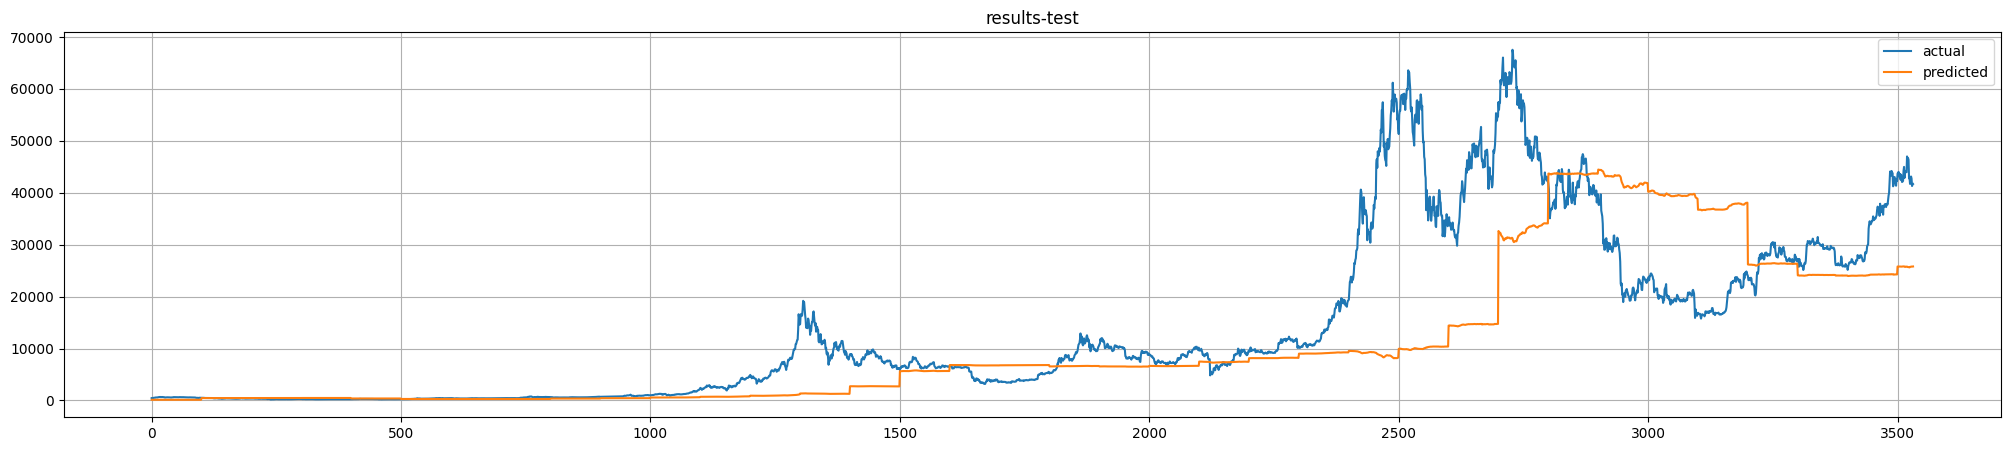

In [37]:
plot_results(lstm_y_test_array,lstm_y_test_pred_array,'results-test')

In [38]:
lstm_result_metrics_df

batch_id     mae_train    rmse_train      mae_test     rmse_test
0          0    221.680641    337.152647    455.229347    458.034826
1          1    232.681671    265.298801     66.343088     73.916419
2          2    180.693064    224.541361    195.380136    201.058316
3          3    151.296965    185.974819    236.414069    236.744479
4          4    126.827783    146.650213    126.984547    129.051581
5          5    105.204738    147.835160     81.339918     97.139531
6          6     62.245075     80.454726    128.413260    129.956807
7          7     64.245844     81.472471    286.092652    303.640491
8          8    105.477992    129.197850    253.435389    256.129851
9          9    115.853623    142.645299    412.177743    425.552126
10        10    150.273302    180.483714    710.305080    759.299775
11        11    237.128562    339.824690   2208.459050   2315.664739
12        12    613.957681   1019.297498   5424.415918   6036.909061
13        13   1593.086508   2741.690049  10619.142258  11031.452571
14        14   3290.168409   4880.204634   5110.595191   5208.834332
15        15   3231.156332   3921.076484   1082.223192   1200.384216
16        16   2505.880255   3429.116742   1882.158699   2254.782982
17        17   2123.426641   3121.154239   2686.579644   2754.222186
18        18   2214.201411   3176.185741   2589.222199   3024.509026
19        19   1663.974141   2119.769679   2997.665524   3199.391209
20        20   1983.012335   2422.411651   1565.087806   1855.274842
21        21   2098.541115   2453.629952   1217.624998   1411.000203
22        22   1792.671337   2245.427872   2078.946173   2325.704494
23        23   1245.834479   1549.780795   4861.358987   5830.758471
24        24   1862.412439   2837.831195  31994.901207  34076.246302
25        25   7863.831083  14917.178842  36785.428798  38281.385421
26        26  13720.076336  20073.284445  28515.828471  29237.006863
27        27  14832.490017  16885.116688  21635.046129  23318.081992
28        28  12853.509138  15456.549397   3359.691730   3932.081428
29        29   7641.218553   9322.415580  16432.516330  17033.557196
30        30   9094.884609  11337.247007  19414.322600  19467.625634
31        31  10805.388764  12947.194125  17893.789366  18069.397249
32        32  11902.670699  15335.006035   2058.304516   2410.081816
33        33   6548.584169   8685.610257   4208.835295   4595.619358
34        34   4016.375267   4671.349281   9364.431483  11013.392926
35        35   4788.479034   6093.615946  17733.560007  17793.609071

In [39]:
pd.DataFrame(lstm_result_metrics_df.mean()).drop(['batch_id'])

0
mae_train   3667.762223
rmse_train  4830.657664
mae_test    7129.784745
rmse_test   7520.763827

## BI-LSTM

Callbacks

EarlyStopping

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(monitor='root_mean_squared_error',min_delta=1e-3,patience=50,verbose=100,mode='min')

Learning Rate Scheduler

In [41]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
def changeLearningRate(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

lrschedule=LearningRateScheduler(changeLearningRate, verbose=1)

In [42]:
reduce_lr=ReduceLROnPlateau(monitor='root_mean_squared_error', factor=0.98,patience=3,verbose=1,mode='min')

In [43]:
callback_list=[reduce_lr,lrschedule,earlystop]

Build the Model

In [44]:
input_layer = Input(shape=(1, 10),name='input_layer')
lstm_1 = Bidirectional(LSTM(400, return_sequences=True,activation='relu'),name='lstm_1')(input_layer)
dropout_1 = Dropout(0.25,name='dropout_1')(lstm_1)
lstm_2 = Bidirectional(LSTM(500, return_sequences=True,activation='relu'),name='lstm_2')(dropout_1)
dropout_2 = Dropout(0.3,name='dropout_2')(lstm_2)

output_layer = Dense(1,name='output_layer')(dropout_2)

model=Model(inputs=input_layer,outputs=output_layer)
adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(optimizer=adam, loss='log_cosh',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 10)]           0         
                                                                 
 lstm_1 (Bidirectional)      (None, 1, 800)            1315200   
                                                                 
 dropout_1 (Dropout)         (None, 1, 800)            0         
                                                                 
 lstm_2 (Bidirectional)      (None, 1, 1000)           5204000   
                                                                 
 dropout_2 (Dropout)         (None, 1, 1000)           0         
                                                                 
 output_layer (Dense)        (None, 1, 1)              1001      
                                                                 
Total params: 6520201 (24.87 MB)
Trainable params: 6520201 

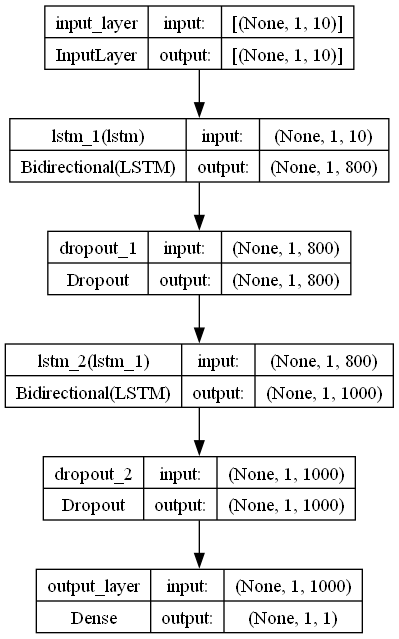

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [47]:
bilstm_date_array = []
bilstm_y_test_array = []
bilstm_y_test_pred_array = []
bilstm_batch_id_array = []
bilstm_batch_id_array_result = []
bilstm_batch_mae_train_array = []
bilstm_batch_rmse_train_array = []
bilstm_batch_mae_test_array = []
bilstm_batch_rmse_test_array = []

for i in range(len(train_splits)):
    # print(f'Batch No. {i+1} of {len(train_splits)}')
    # print('Train Data From',train_splits[i]['Date'].iloc[0],'-',train_splits[i]['next_day_closing_price'].min(),
    #       'to',train_splits[i]['Date'].iloc[-1],'-',train_splits[i]['next_day_closing_price'].max())
    
    # print('Test Data From',test_splits[i]['Date'].iloc[0],'-',test_splits[i]['next_day_closing_price'].min(),
    #       'to',test_splits[i]['Date'].iloc[-1],'-',test_splits[i]['next_day_closing_price'].max())
    
    del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(optimizer=adam, loss='Huber',metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1).values

    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    Xtrain_split=np.reshape(Xtrain_split,(Xtrain_split.shape[0],1,Xtrain_split.shape[1]))
    Xtest_split=np.reshape(Xtest_split,(Xtest_split.shape[0],1,Xtest_split.shape[1]))

    model.fit(Xtrain_split,ytrain_split,epochs=500,batch_size=32,verbose=2,
              callbacks = [reduce_lr,lrschedule,earlystop])
    model.save(f'BI-LSTM/bilstm_{i+1}')
    ytrain_pred = model.predict(Xtrain_split).reshape(-1,1)
    ytest_pred = model.predict(Xtest_split).reshape(-1,1)
    
    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    bilstm_date_array.extend(test_splits[i]['Date'])
    bilstm_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    bilstm_y_test_pred_array.extend((ytest_pred.flatten()))
    bilstm_batch_id_array.extend([i]*len(test_splits[i]))

    bilstm_batch_id_array_result.append(i)
    bilstm_batch_mae_train_array.append(MAE_train)
    bilstm_batch_rmse_train_array.append(RMSE_train)
    bilstm_batch_mae_test_array.append(MAE_test)
    bilstm_batch_rmse_test_array.append(RMSE_test)
    print('*'*100)

bilstm_result_test_df = pd.DataFrame()
bilstm_result_test_df['batch_id'] = bilstm_batch_id_array
bilstm_result_test_df['Date'] = bilstm_date_array
bilstm_result_test_df['y_test'] = bilstm_y_test_array
bilstm_result_test_df['y_test_pred'] = bilstm_y_test_pred_array
bilstm_y_test_array = bilstm_result_test_df['y_test']
bilstm_y_test_pred_array = bilstm_result_test_df['y_test_pred']

bilstm_result_metrics_df = pd.DataFrame()
bilstm_result_metrics_df['batch_id'] = bilstm_batch_id_array_result
bilstm_result_metrics_df['mae_train'] = bilstm_batch_mae_train_array
bilstm_result_metrics_df['rmse_train'] = bilstm_batch_rmse_train_array
bilstm_result_metrics_df['mae_test'] = bilstm_batch_mae_test_array
bilstm_result_metrics_df['rmse_test'] = bilstm_batch_rmse_test_array 


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 303.6971 - root_mean_squared_error: 420.6987 - mae: 304.1971 - lr: 0.0010 - 4s/epoch - 277ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 303.1938 - root_mean_squared_error: 418.8424 - mae: 303.6938 - lr: 0.0010 - 745ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 301.2190 - root_mean_squared_error: 418.7282 - mae: 301.7190 - lr: 0.0010 - 747ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 294.4232 - root_mean_squared_error: 414.1303 - mae: 294.9227 - lr: 0.0010 - 751ms/epoch - 47ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0009800000465475024.
Epoch 5/500
16/16 - 1s - loss: 275.5693 - root_mean_squared_error: 398.3683 - mae: 276.0677 - 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_1\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 291.7112 - root_mean_squared_error: 380.0545 - mae: 292.2107 - lr: 0.0010 - 4s/epoch - 274ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 272.7357 - root_mean_squared_error: 319.7463 - mae: 273.2357 - lr: 0.0010 - 747ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 251.9558 - root_mean_squared_error: 282.0512 - mae: 252.4555 - lr: 0.0010 - 744ms/epoch - 46ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 245.1979 - root_mean_squared_error: 282.9922 - mae: 245.6975 - lr: 0.0010 - 743ms/epoch - 46ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_2\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 188.0219 - root_mean_squared_error: 233.1139 - mae: 188.5212 - lr: 0.0010 - 5s/epoch - 322ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 188.0410 - root_mean_squared_error: 233.5263 - mae: 188.5405 - lr: 0.0010 - 891ms/epoch - 56ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 187.7911 - root_mean_squared_error: 232.8142 - mae: 188.2904 - lr: 0.0010 - 897ms/epoch - 56ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 188.2052 - root_mean_squared_error: 233.1882 - mae: 188.7046 - lr: 0.0010 - 909ms/epoch - 57ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_3\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 157.3802 - root_mean_squared_error: 194.2968 - mae: 157.8797 - lr: 0.0010 - 6s/epoch - 355ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 157.0860 - root_mean_squared_error: 194.5744 - mae: 157.5853 - lr: 0.0010 - 749ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 157.2839 - root_mean_squared_error: 194.7740 - mae: 157.7834 - lr: 0.0010 - 757ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 157.4372 - root_mean_squared_error: 195.4590 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_4\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 137.3948 - root_mean_squared_error: 156.5943 - mae: 137.8942 - lr: 0.0010 - 5s/epoch - 321ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 131.3574 - root_mean_squared_error: 154.2573 - mae: 131.8566 - lr: 0.0010 - 921ms/epoch - 58ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 130.9140 - root_mean_squared_error: 153.0086 - mae: 131.4132 - lr: 0.0010 - 912ms/epoch - 57ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 130.6976 - root_mean_squared_error: 151.6093 - mae: 131.1972 - lr: 0.0010 - 897ms/epoch - 56ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_5\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 116.5720 - root_mean_squared_error: 142.2932 - mae: 117.0711 - lr: 0.0010 - 5s/epoch - 319ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 107.5703 - root_mean_squared_error: 152.9892 - mae: 108.0690 - lr: 0.0010 - 926ms/epoch - 58ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 108.0980 - root_mean_squared_error: 154.8432 - mae: 108.5970 - lr: 0.0010 - 895ms/epoch - 56ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 107.4968 - root_mean_squared_error: 151.0276 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_6\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 64.0771 - root_mean_squared_error: 81.3816 - mae: 64.5757 - lr: 0.0010 - 5s/epoch - 324ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 63.7534 - root_mean_squared_error: 84.6373 - mae: 64.2518 - lr: 0.0010 - 901ms/epoch - 56ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 63.9348 - root_mean_squared_error: 84.2018 - mae: 64.4331 - lr: 0.0010 - 935ms/epoch - 58ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 63.8873 - root_mean_squared_error: 83.9577 - mae: 64.3

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_7\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 66.2652 - root_mean_squared_error: 85.2697 - mae: 66.7637 - lr: 0.0010 - 5s/epoch - 320ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 66.2917 - root_mean_squared_error: 84.1219 - mae: 66.7900 - lr: 0.0010 - 913ms/epoch - 57ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 66.1419 - root_mean_squared_error: 82.9883 - mae: 66.6408 - lr: 0.0010 - 894ms/epoch - 56ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 66.3309 - root_mean_squared_error: 85.3706 - mae: 66.8294 - lr: 0.0010 - 922ms/epoch - 58ms/step

Epoch 5: LearningRateScheduler se

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_8\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 113.6094 - root_mean_squared_error: 150.0210 - mae: 114.1090 - lr: 0.0010 - 5s/epoch - 320ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 109.2860 - root_mean_squared_error: 137.4665 - mae: 109.7855 - lr: 0.0010 - 752ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 110.3164 - root_mean_squared_error: 135.1438 - mae: 110.8158 - lr: 0.0010 - 735ms/epoch - 46ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 109.2283 - root_mean_squared_error: 134.3879 - mae: 109.7280 - lr: 0.0010 - 736ms/epoch - 46ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_9\assets


4/4 [==============================] - 0s 3ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 127.2720 - root_mean_squared_error: 157.1406 - mae: 127.7711 - lr: 0.0010 - 4s/epoch - 259ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 122.5539 - root_mean_squared_error: 148.0589 - mae: 123.0523 - lr: 0.0010 - 735ms/epoch - 46ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 121.3693 - root_mean_squared_error: 148.6056 - mae: 121.8681 - lr: 0.0010 - 742ms/epoch - 46ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 121.5324 - root_mean_squared_error: 148.4911 - mae: 122.0307 - lr: 0.0010 - 734ms/epoch - 46ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_10\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 163.4853 - root_mean_squared_error: 213.1581 - mae: 163.9847 - lr: 0.0010 - 6s/epoch - 350ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 158.8876 - root_mean_squared_error: 193.5061 - mae: 159.3874 - lr: 0.0010 - 742ms/epoch - 46ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 161.1934 - root_mean_squared_error: 193.0201 - mae: 161.6931 - lr: 0.0010 - 737ms/epoch - 46ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 158.7108 - root_mean_squared_error: 191.2634 - mae: 159.2106 - lr: 0.0010 - 739ms/epoch - 46ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_11\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 253.0279 - root_mean_squared_error: 372.6920 - mae: 253.5273 - lr: 0.0010 - 4s/epoch - 275ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 250.6789 - root_mean_squared_error: 344.6447 - mae: 251.1785 - lr: 0.0010 - 770ms/epoch - 48ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 248.9417 - root_mean_squared_error: 361.9344 - mae: 249.4409 - lr: 0.0010 - 758ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 248.1055 - root_mean_squared_error: 356.7024 - mae: 248.6047 - lr: 0.0010 - 752ms/epoch - 47ms/step

Epoch 5: LearningRate

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_12\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 638.3477 - root_mean_squared_error: 1079.4048 - mae: 638.8474 - lr: 0.0010 - 4s/epoch - 276ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 631.1013 - root_mean_squared_error: 1030.4757 - mae: 631.6011 - lr: 0.0010 - 743ms/epoch - 46ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 630.6301 - root_mean_squared_error: 1025.0448 - mae: 631.1300 - lr: 0.0010 - 761ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 628.9481 - root_mean_squared_error: 1047.1683 - mae: 629.4479 - lr: 0.0010 - 744ms/epoch - 47ms/step

Epoch 5: Learning

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_13\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 1649.0916 - root_mean_squared_error: 2886.5703 - mae: 1649.5913 - lr: 0.0010 - 4s/epoch - 250ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1615.8640 - root_mean_squared_error: 2751.1541 - mae: 1616.3639 - lr: 0.0010 - 724ms/epoch - 45ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1617.6725 - root_mean_squared_error: 2704.9368 - mae: 1618.1725 - lr: 0.0010 - 722ms/epoch - 45ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1614.6527 - root_mean_squared_error: 2769.2136 - mae: 1615.1527 - lr: 0.0010 - 719ms/epoch - 45ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_14\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 3589.9648 - root_mean_squared_error: 5588.0352 - mae: 3590.4648 - lr: 0.0010 - 5s/epoch - 331ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 3432.6162 - root_mean_squared_error: 5283.9922 - mae: 3433.1162 - lr: 0.0010 - 725ms/epoch - 45ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 3375.5947 - root_mean_squared_error: 4944.2886 - mae: 3376.0947 - lr: 0.0010 - 724ms/epoch - 45ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 3350.5173 - root_mean_squared_error: 4859.1802 - mae: 3351.0173 - lr: 0.0010 - 724ms/epoch - 45ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_15\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 3897.9951 - root_mean_squared_error: 5214.5103 - mae: 3898.4951 - lr: 0.0010 - 4s/epoch - 260ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 3585.8218 - root_mean_squared_error: 4627.2842 - mae: 3586.3218 - lr: 0.0010 - 743ms/epoch - 46ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 3497.2654 - root_mean_squared_error: 4306.6665 - mae: 3497.7654 - lr: 0.0010 - 744ms/epoch - 46ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 3510.4729 - root_mean_squared_error: 4275.1943 - mae: 3510.9729 - lr: 0.0010 - 739ms/epoch - 46ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_16\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 2684.4871 - root_mean_squared_error: 3639.8525 - mae: 2684.9871 - lr: 0.0010 - 4s/epoch - 267ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2596.3086 - root_mean_squared_error: 3487.2771 - mae: 2596.8086 - lr: 0.0010 - 808ms/epoch - 50ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2595.8235 - root_mean_squared_error: 3522.5793 - mae: 2596.3235 - lr: 0.0010 - 836ms/epoch - 52ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2577.0679 - root_mean_squared_error: 3500.9138 - mae: 2577.5679 - lr: 0.0010 - 814ms/epoch - 51ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_17\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 2181.2258 - root_mean_squared_error: 3187.8428 - mae: 2181.7258 - lr: 0.0010 - 4s/epoch - 262ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2181.7021 - root_mean_squared_error: 3187.6699 - mae: 2182.2021 - lr: 0.0010 - 746ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2179.2249 - root_mean_squared_error: 3189.9795 - mae: 2179.7249 - lr: 0.0010 - 748ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2180.0007 - root_mean_squared_error: 3177.5100 - mae: 2180.5007 - lr: 0.0010 - 744ms/epoch - 47ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_18\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 6s - loss: 2280.0378 - root_mean_squared_error: 3215.2698 - mae: 2280.5378 - lr: 0.0010 - 6s/epoch - 356ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2278.9185 - root_mean_squared_error: 3253.1077 - mae: 2279.4182 - lr: 0.0010 - 759ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2274.3804 - root_mean_squared_error: 3234.4221 - mae: 2274.8804 - lr: 0.0010 - 765ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 2275.5073 - root_mean_squared_error:

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_19\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 1728.5579 - root_mean_squared_error: 2173.8845 - mae: 1729.0579 - lr: 0.0010 - 4s/epoch - 263ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1726.0265 - root_mean_squared_error: 2173.1050 - mae: 1726.5265 - lr: 0.0010 - 751ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1726.5486 - root_mean_squared_error: 2180.7837 - mae: 1727.0485 - lr: 0.0010 - 749ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1724.5455 - root_mean_squared_error: 2181.9929 - mae: 1725.0454 - lr: 0.0010 - 750ms/epoch - 47ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_20\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 2056.4731 - root_mean_squared_error: 2503.1609 - mae: 2056.9731 - lr: 0.0010 - 4s/epoch - 261ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2053.4866 - root_mean_squared_error: 2504.0220 - mae: 2053.9866 - lr: 0.0010 - 749ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2051.5955 - root_mean_squared_error: 2493.0405 - mae: 2052.0955 - lr: 0.0010 - 763ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2053.1204 - root_mean_squared_error: 2497.7959 - mae: 2053.6204 - lr: 0.0010 - 764ms/epoch - 48ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_21\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 2248.2805 - root_mean_squared_error: 2594.1155 - mae: 2248.7805 - lr: 0.0010 - 5s/epoch - 311ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 2215.2800 - root_mean_squared_error: 2589.7600 - mae: 2215.7800 - lr: 0.0010 - 894ms/epoch - 56ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 2209.7610 - root_mean_squared_error: 2586.4565 - mae: 2210.2610 - lr: 0.0010 - 882ms/epoch - 55ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 2210.8591 - root_mean_squared_error: 2586.7661 - mae: 2211.3591 - lr: 0.0010 - 923ms/epoch - 58ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_22\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 1913.7278 - root_mean_squared_error: 2347.4495 - mae: 1914.2278 - lr: 0.0010 - 5s/epoch - 314ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1897.3813 - root_mean_squared_error: 2384.4836 - mae: 1897.8813 - lr: 0.0010 - 831ms/epoch - 52ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1893.3739 - root_mean_squared_error: 2346.7839 - mae: 1893.8737 - lr: 0.0010 - 835ms/epoch - 52ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1885.9380 - root_mean_squared_error: 2355.5564 - mae: 1886.4380 - lr: 0.0010 - 801ms/epoch - 50ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_23\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 1408.8960 - root_mean_squared_error: 1743.5710 - mae: 1409.3960 - lr: 0.0010 - 5s/epoch - 289ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1345.5526 - root_mean_squared_error: 1678.6605 - mae: 1346.0526 - lr: 0.0010 - 791ms/epoch - 49ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1331.3351 - root_mean_squared_error: 1664.3844 - mae: 1331.8350 - lr: 0.0010 - 777ms/epoch - 49ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1337.9816 - root_mean_squared_error: 1661.9839 - mae: 1338.4816 - lr: 0.0010 - 843ms/epoch - 53ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_24\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 1981.6371 - root_mean_squared_error: 2961.2659 - mae: 1982.1370 - lr: 0.0010 - 5s/epoch - 288ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 1941.8350 - root_mean_squared_error: 2923.9106 - mae: 1942.3350 - lr: 0.0010 - 906ms/epoch - 57ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 1936.6281 - root_mean_squared_error: 2919.3025 - mae: 1937.1281 - lr: 0.0010 - 961ms/epoch - 60ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 1940.6727 - root_mean_squared_error: 2899.4026 - mae: 1941.1727 - lr: 0.0010 - 885ms/epoch - 55ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_25\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 8021.5854 - root_mean_squared_error: 15099.4561 - mae: 8022.0854 - lr: 0.0010 - 5s/epoch - 284ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 7999.9331 - root_mean_squared_error: 14720.3438 - mae: 8000.4331 - lr: 0.0010 - 859ms/epoch - 54ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 7981.5444 - root_mean_squared_error: 15042.7861 - mae: 7982.0444 - lr: 0.0010 - 873ms/epoch - 55ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 7988.8682 - root_mean_squared_error: 14883.2285 - mae: 7989.3682 - lr: 0.0010 - 822ms/epoch - 51ms/step

Epoch

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_26\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 14721.7520 - root_mean_squared_error: 22065.8262 - mae: 14722.2520 - lr: 0.0010 - 5s/epoch - 287ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 14521.6748 - root_mean_squared_error: 20866.4961 - mae: 14522.1748 - lr: 0.0010 - 787ms/epoch - 49ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 14543.7246 - root_mean_squared_error: 20433.5293 - mae: 14544.2246 - lr: 0.0010 - 776ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 14567.8008 - root_mean_squared_error: 20795.3027 - mae: 14568.3008 - lr: 0.0010 - 792ms/epoch - 49ms/ste

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_27\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 18564.0352 - root_mean_squared_error: 23372.7676 - mae: 18564.5352 - lr: 0.0010 - 4s/epoch - 274ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 16659.3887 - root_mean_squared_error: 19507.4707 - mae: 16659.8887 - lr: 0.0010 - 804ms/epoch - 50ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 16329.0273 - root_mean_squared_error: 19067.6133 - mae: 16329.5273 - lr: 0.0010 - 776ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 16189.6865 - root_mean_squared_error: 18608.2832 - mae: 16190.1865 - lr: 0.0010 - 760ms/epoch - 48ms/ste

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_28\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 14170.2969 - root_mean_squared_error: 16803.1973 - mae: 14170.7969 - lr: 0.0010 - 4s/epoch - 248ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 13339.6494 - root_mean_squared_error: 16485.2812 - mae: 13340.1494 - lr: 0.0010 - 736ms/epoch - 46ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 13357.8594 - root_mean_squared_error: 16369.6904 - mae: 13358.3594 - lr: 0.0010 - 740ms/epoch - 46ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 13382.0996 - root_mean_squared_error: 16396.8398 - mae: 13382.5996 - lr: 0.0010 - 736ms/epoch - 46ms/ste

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_29\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 8087.2139 - root_mean_squared_error: 9956.4795 - mae: 8087.7139 - lr: 0.0010 - 4s/epoch - 259ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 8063.7920 - root_mean_squared_error: 9842.0518 - mae: 8064.2920 - lr: 0.0010 - 763ms/epoch - 48ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 8109.8096 - root_mean_squared_error: 10023.5371 - mae: 8110.3096 - lr: 0.0010 - 763ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 8081.5220 - root_mean_squared_error: 9904.3711 - mae: 8082.0220 - lr: 0.0010 - 758ms/epoch - 47ms/step

Epoch 5:

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_30\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 9567.0342 - root_mean_squared_error: 11915.5586 - mae: 9567.5342 - lr: 0.0010 - 4s/epoch - 257ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 9529.5527 - root_mean_squared_error: 11878.6230 - mae: 9530.0527 - lr: 0.0010 - 757ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 9443.3662 - root_mean_squared_error: 11750.8076 - mae: 9443.8662 - lr: 0.0010 - 753ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 9489.2061 - root_mean_squared_error: 11822.3691 - mae: 9489.7061 - lr: 0.0010 - 751ms/epoch - 47ms/step

Epoch

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_31\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 11493.6025 - root_mean_squared_error: 13937.2832 - mae: 11494.1025 - lr: 0.0010 - 4s/epoch - 254ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 11486.2686 - root_mean_squared_error: 13526.1279 - mae: 11486.7686 - lr: 0.0010 - 760ms/epoch - 47ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 11388.1797 - root_mean_squared_error: 13551.4346 - mae: 11388.6797 - lr: 0.0010 - 755ms/epoch - 47ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 11399.2383 - root_mean_squared_error: 13679.8008 - mae: 11399.7383 - lr: 0.0010 - 760ms/epoch - 47ms/ste

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_32\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 13328.2314 - root_mean_squared_error: 15029.3877 - mae: 13328.7314 - lr: 0.0010 - 4s/epoch - 270ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 12471.4531 - root_mean_squared_error: 14473.7637 - mae: 12471.9531 - lr: 0.0010 - 776ms/epoch - 48ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 12212.4551 - root_mean_squared_error: 14927.5977 - mae: 12212.9551 - lr: 0.0010 - 774ms/epoch - 48ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 12183.4824 - root_mean_squared_error: 15423.5000 - mae: 12183.9824 - lr: 0.0010 - 776ms/epoch - 49ms/ste

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_33\assets


4/4 [==============================] - 0s 4ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 4s - loss: 6878.3916 - root_mean_squared_error: 8660.6719 - mae: 6878.8916 - lr: 0.0010 - 4s/epoch - 267ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 6800.7168 - root_mean_squared_error: 8881.1016 - mae: 6801.2168 - lr: 0.0010 - 809ms/epoch - 51ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 6822.0845 - root_mean_squared_error: 9087.5332 - mae: 6822.5845 - lr: 0.0010 - 817ms/epoch - 51ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009800000465475024.
16/16 - 1s - loss: 6815.8604 - root_mean_squared_error:

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_34\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 4283.6270 - root_mean_squared_error: 5029.0815 - mae: 4284.1270 - lr: 0.0010 - 5s/epoch - 313ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 4274.6030 - root_mean_squared_error: 4995.3682 - mae: 4275.1030 - lr: 0.0010 - 888ms/epoch - 56ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 4270.8657 - root_mean_squared_error: 4978.3652 - mae: 4271.3657 - lr: 0.0010 - 903ms/epoch - 56ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 4291.4912 - root_mean_squared_error: 5031.7783 - mae: 4291.9912 - lr: 0.0010 - 831ms/epoch - 52ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_35\assets


4/4 [==============================] - 0s 5ms/step
****************************************************************************************************

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/500
16/16 - 5s - loss: 5135.5371 - root_mean_squared_error: 6466.5835 - mae: 5136.0371 - lr: 0.0010 - 5s/epoch - 288ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/500
16/16 - 1s - loss: 5030.4888 - root_mean_squared_error: 6409.4897 - mae: 5030.9888 - lr: 0.0010 - 804ms/epoch - 50ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/500
16/16 - 1s - loss: 5040.6504 - root_mean_squared_error: 6393.1299 - mae: 5041.1504 - lr: 0.0010 - 789ms/epoch - 49ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/500
16/16 - 1s - loss: 5033.7588 - root_mean_squared_error: 6384.9863 - mae: 5034.2588 - lr: 0.0010 - 776ms/epoch - 49ms/step

Epoch 5: 

INFO:tensorflow:Assets written to: BI-LSTM/bilstm_36\assets


1/1 [==============================] - 0s 24ms/step
****************************************************************************************************


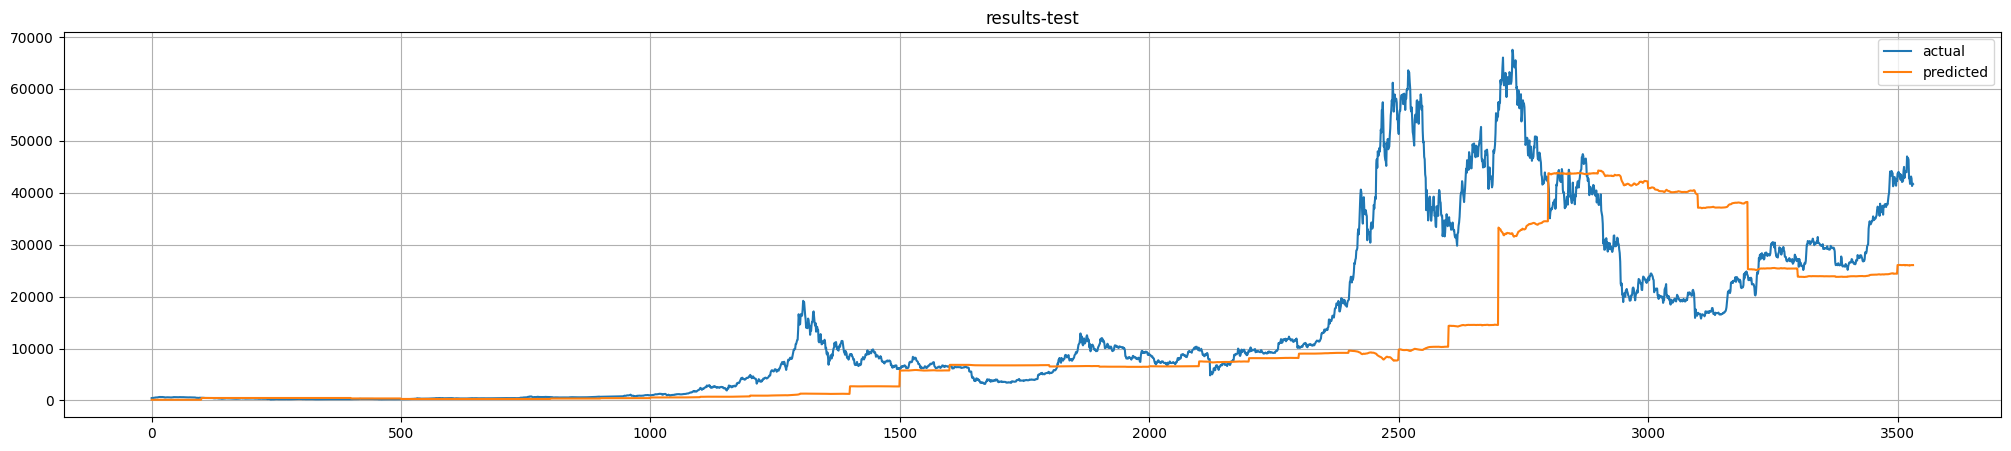

In [49]:
plot_results(bilstm_y_test_array,bilstm_y_test_pred_array,'results-test')

In [50]:
bilstm_result_metrics_df

batch_id     mae_train    rmse_train      mae_test     rmse_test
0          0    222.777319    339.655290    459.162573    461.968025
1          1    234.753218    269.548826     73.935982     84.311744
2          2    181.392926    225.461119    199.689709    205.285420
3          3    151.676951    187.214940    231.296051    231.635867
4          4    126.487440    146.064699    127.759826    129.802859
5          5    104.850226    148.227556     82.139718     98.256197
6          6     62.063998     80.989231    130.315515    131.829937
7          7     64.097657     81.432790    285.837165    303.322467
8          8    104.738678    128.291895    251.595613    254.276689
9          9    115.898077    142.403264    409.636121    423.115540
10        10    150.360598    180.222752    706.282797    755.687230
11        11    238.025855    340.596999   2215.804145   2323.593589
12        12    612.039695   1014.449365   5405.100792   6017.063858
13        13   1596.384918   2746.563007  10644.160371  11057.699557
14        14   3291.165027   4887.246111   5121.717822   5219.837741
15        15   3284.846610   3979.966222    979.573925   1112.262552
16        16   2500.916725   3419.535222   1909.170110   2274.367207
17        17   2125.504315   3130.531619   2671.899292   2739.698563
18        18   2215.552570   3183.551944   2600.525036   3037.833396
19        19   1666.727862   2124.582631   3045.630886   3245.548553
20        20   1986.508651   2437.253344   1629.621576   1912.067324
21        21   2103.589199   2462.307612   1214.205848   1400.063851
22        22   1807.207158   2263.671255   2093.141530   2343.226065
23        23   1251.891569   1557.328345   4897.122659   5878.766416
24        24   1863.244040   2827.155593  32198.629186  34321.117208
25        25   7860.302747  14952.059905  36890.122157  38395.449028
26        26  13745.585830  20165.595751  28634.879008  29363.177078
27        27  14785.817223  16843.794135  20952.499098  22611.907342
28        28  12742.387474  15412.637457   3374.350616   3948.475146
29        29   7695.586662   9399.258220  16649.517619  17293.884870
30        30   9088.970932  11303.277695  20129.277483  20183.463814
31        31  10866.238451  12993.822230  18205.663194  18391.342892
32        32  11772.106449  15435.432925   2584.989620   2805.157236
33        33   6543.746202   8725.032318   4459.057405   4825.964664
34        34   4019.107591   4679.606967   9388.243495  10990.411992
35        35   4800.373160   6114.743331  17433.815806  17493.984697

In [51]:
pd.DataFrame(bilstm_result_metrics_df.mean()).drop(['batch_id'])

0
mae_train   3666.192333
rmse_train  4842.486460
mae_test    7174.621382
rmse_test   7562.940462